# Russo Andrea | CQF EXAM 3 | June 2021 cohort

In [1]:
# Importing libraries

# Numerics and Dataframes
import numpy as np
import numpy.random as rnd
import pandas as pd
import seaborn as sns

# Plotting
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = [10.0, 6.0] 
mpl.rcParams["legend.frameon"] = False
mpl.rcParams['figure.dpi']=200 

# Ticker data downloading
import yfinance as yf

# Sklearn 
import sklearn

# Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay, auc, roc_curve, RocCurveDisplay

# Data Preprocessing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler, PowerTransformer, RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


# Sigmoid plotting
from scipy.special import expit

# Classifier
from sklearn.linear_model import LogisticRegression

# Feature Selection using VIF
from statsmodels.stats.outliers_influence import variance_inflation_factor

# Feature Selection using Kbest
from sklearn.feature_selection import f_regression, SelectKBest, SelectPercentile

# Feature Selection using RFE and RFECV
from sklearn.feature_selection import RFECV, RFE

# Feature Selection using Shapley Additive Explanation
import shap

# Data retrieval and dataframe creation

In [2]:
# Retrieve data
palantir= yf.download('PLTR',start="2017-10-28", end="2021-10-28",progress=False)
palantir.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-09-30,10.00,11.41,9.11,9.50,9.50,338584400
2020-10-01,9.69,10.10,9.23,9.46,9.46,124297600
2020-10-02,9.06,9.28,8.94,9.20,9.20,55018300
2020-10-05,9.43,9.49,8.92,9.03,9.03,36316900
2020-10-06,9.04,10.18,8.90,9.90,9.90,90864000


In [3]:
# Save to Excel
palantir.to_csv("Palantir.csv")

In [4]:
# Subsume into Pandas dataframe
df = pd.read_csv('Palantir.csv', index_col=0, parse_dates=True).drop(columns='Volume') # Dropping volume for clarity
df.head(3)

,Open,High,Low,Close,Adj Close
Date,,,,,
2020-09-30,10.00,11.41,9.11,9.50,9.50
2020-10-01,9.69,10.10,9.23,9.46,9.46
2020-10-02,9.06,9.28,8.94,9.20,9.20


In [5]:
# Compute returns
df['Returns']=df['Adj Close'].pct_change().fillna(0)
df.head(3)

,Open,High,Low,Close,Adj Close,Returns
Date,,,,,,
2020-09-30,10.00,11.41,9.11,9.50,9.50,0.000000
2020-10-01,9.69,10.10,9.23,9.46,9.46,-0.004211
2020-10-02,9.06,9.28,8.94,9.20,9.20,-0.027484


# Part 1: Feature Scaling and Selection
We will proceed in this order:
- We define the target


- We discuss and define the features


- We study the correlation between the different features with a heathmap


- We split data into training and validation sets and discuss the appropriate choice of scaling


- We construct an appropriate transformer which scales each feature correctly

## Target definition
We define the target by assigning the value of **1** if the adjusted price at closing is greater than the price of the day before. To be precise, we consider it an increase in price only if the growth is more than 0.1%. All the other values are considered as **0**.

In [6]:
# Define the target

y = np.where(df['Adj Close'].shift(-1)>0.999*df['Adj Close'],1,0)
y[:10]

array([0, 0, 0, 1, 1, 1, 0, 0, 0, 0])

## Feature definition and correlation heathmap:
- We first discuss how far into the past the features should probe when defining a model for a 1-day forecast.


- Subsequently, we create a dataframe to containt the features of the model and we study their correlations with the help of a heathmap.

### Would it make sense to use fifty-days back data to predict a 1 day-return?

Price Momentum to predict a one-day return (sign)?
When predicting a 1 day return in a time series, it is important to consider how far back in the past the data that we will use as predictors should go. The general rule of thumb when forecasting a time series is that a decent model should have more observations than parameters, meaning that for most time series the predictor data should have as many observations as the period of maximum expected seasonality. 

Generally, for short term forecasting, data up to 20 days in the past is used. Medium term forecasting uses data from 20 to 60 days while long term forecasting exploits data that can stretch for years in the past.

Given that we are trying to predict a 1-day move, we are allowed to ignore any seasonality behaviour of returns. Moreover, for short term forecasting, we need to employ predictors which are capable of move quickly with price swings. This means that, for the purpose of this exercise, it should be enough to consider lagged returns, momentum and SMA/EMA that do not stretch further than 20 dyas. 

This allows for a better forecasting of short term trends and a more accurate 1-day price sign prediction.

### A quick word on moving averages
Moving averages for short returns tend to be very highly correlated, therefore we have chosen not to include many of them.

In [7]:
# Create Dataframe for Features with same index as the retrieved one
Features=pd.DataFrame(index=df.index)

In [8]:
# Compute 5 days lagged returns
lags=range(1,11,2)

cols=[]
for i in lags:
    col= 'Ret %d' % i
    Features[col]=df['Returns'].shift(i)
    cols.append(col)

In [9]:
# Compute sign of returns

Features['Ret sign']=np.sign(df['Returns'].values)

In [10]:
# Compute Open-Close and High-Low

Features['O-C']=df['Open']-df['Close']
Features['H-L']=df['High']-df['Low']
Features.head(3)

,Ret 1,Ret 3,Ret 5,Ret 7,Ret 9,Ret sign,O-C,H-L
Date,,,,,,,,
2020-09-30,NaN,NaN,NaN,NaN,NaN,0.0,0.500000,2.300000
2020-10-01,0.000000,NaN,NaN,NaN,NaN,-1.0,0.230000,0.870001
2020-10-02,-0.004211,NaN,NaN,NaN,NaN,-1.0,-0.139999,0.340000


In [11]:
Features.head(3)

,Ret 1,Ret 3,Ret 5,Ret 7,Ret 9,Ret sign,O-C,H-L
Date,,,,,,,,
2020-09-30,NaN,NaN,NaN,NaN,NaN,0.0,0.500000,2.300000
2020-10-01,0.000000,NaN,NaN,NaN,NaN,-1.0,0.230000,0.870001
2020-10-02,-0.004211,NaN,NaN,NaN,NaN,-1.0,-0.139999,0.340000


In [12]:
# Compute Momentum up to 10 days. The momentum is computed on alternated days with respect to the lagged returns to avoid overlap.
lags=range(2,12,2)

cols=[]
for i in lags:
    col= 'Mom %d' % i
    Features[col]=df['Adj Close']-df['Adj Close'].shift(i)
    cols.append(col)

In [13]:
# Compute Simple Moving Average up to 20th day
lags=range(2,22,5)

cols=[]
for i in lags:
    col= 'SMA %d' % i
    Features[col]=df['Adj Close'].rolling(i).mean()
    cols.append(col)

In [14]:
# Compute Exponential Moving Average up to 20th day, alternating with the SMA
lags=range(1,21,5)

cols=[]
for i in lags:
    col= 'EMA %d' % i
    Features[col]=df['Adj Close'].ewm(span=i,min_periods=i,adjust=False,ignore_na=False).mean()
    cols.append(col)

In [15]:
#Drop Nan Values
Features.dropna(inplace=True)

In [16]:
Features.head(3)

,Ret 1,Ret 3,Ret 5,Ret 7,Ret 9,Ret sign,O-C,H-L,Mom 2,Mom 4,...,Mom 8,Mom 10,SMA 2,SMA 7,SMA 12,SMA 17,EMA 1,EMA 6,EMA 11,EMA 16
Date,,,,,,,,,,,,,,,,,,,,,
2020-10-22,-0.007551,-0.014418,0.061028,-0.042467,-0.005000,1.0,-0.31,0.53,0.41,-0.030000,...,-0.21,-0.320000,9.440,9.525714,9.665833,9.592941,9.68,9.516199,9.552635,9.563512
2020-10-23,0.052174,-0.031348,-0.020182,-0.013728,-0.006030,-1.0,0.22,0.36,0.29,-0.080000,...,0.02,-0.460000,9.585,9.547143,9.623333,9.592353,9.49,9.508714,9.542196,9.554864
2020-10-26,-0.019628,-0.007551,-0.014418,0.061028,-0.042467,1.0,-0.23,0.37,0.27,0.679999,...,0.61,0.059999,9.720,9.552857,9.619167,9.621176,9.95,9.634795,9.610163,9.601350


In [17]:
# Compute correlation of indicators
corrmat = Features.corr()

Text(0.5, 1.0, 'Feature Correlation')

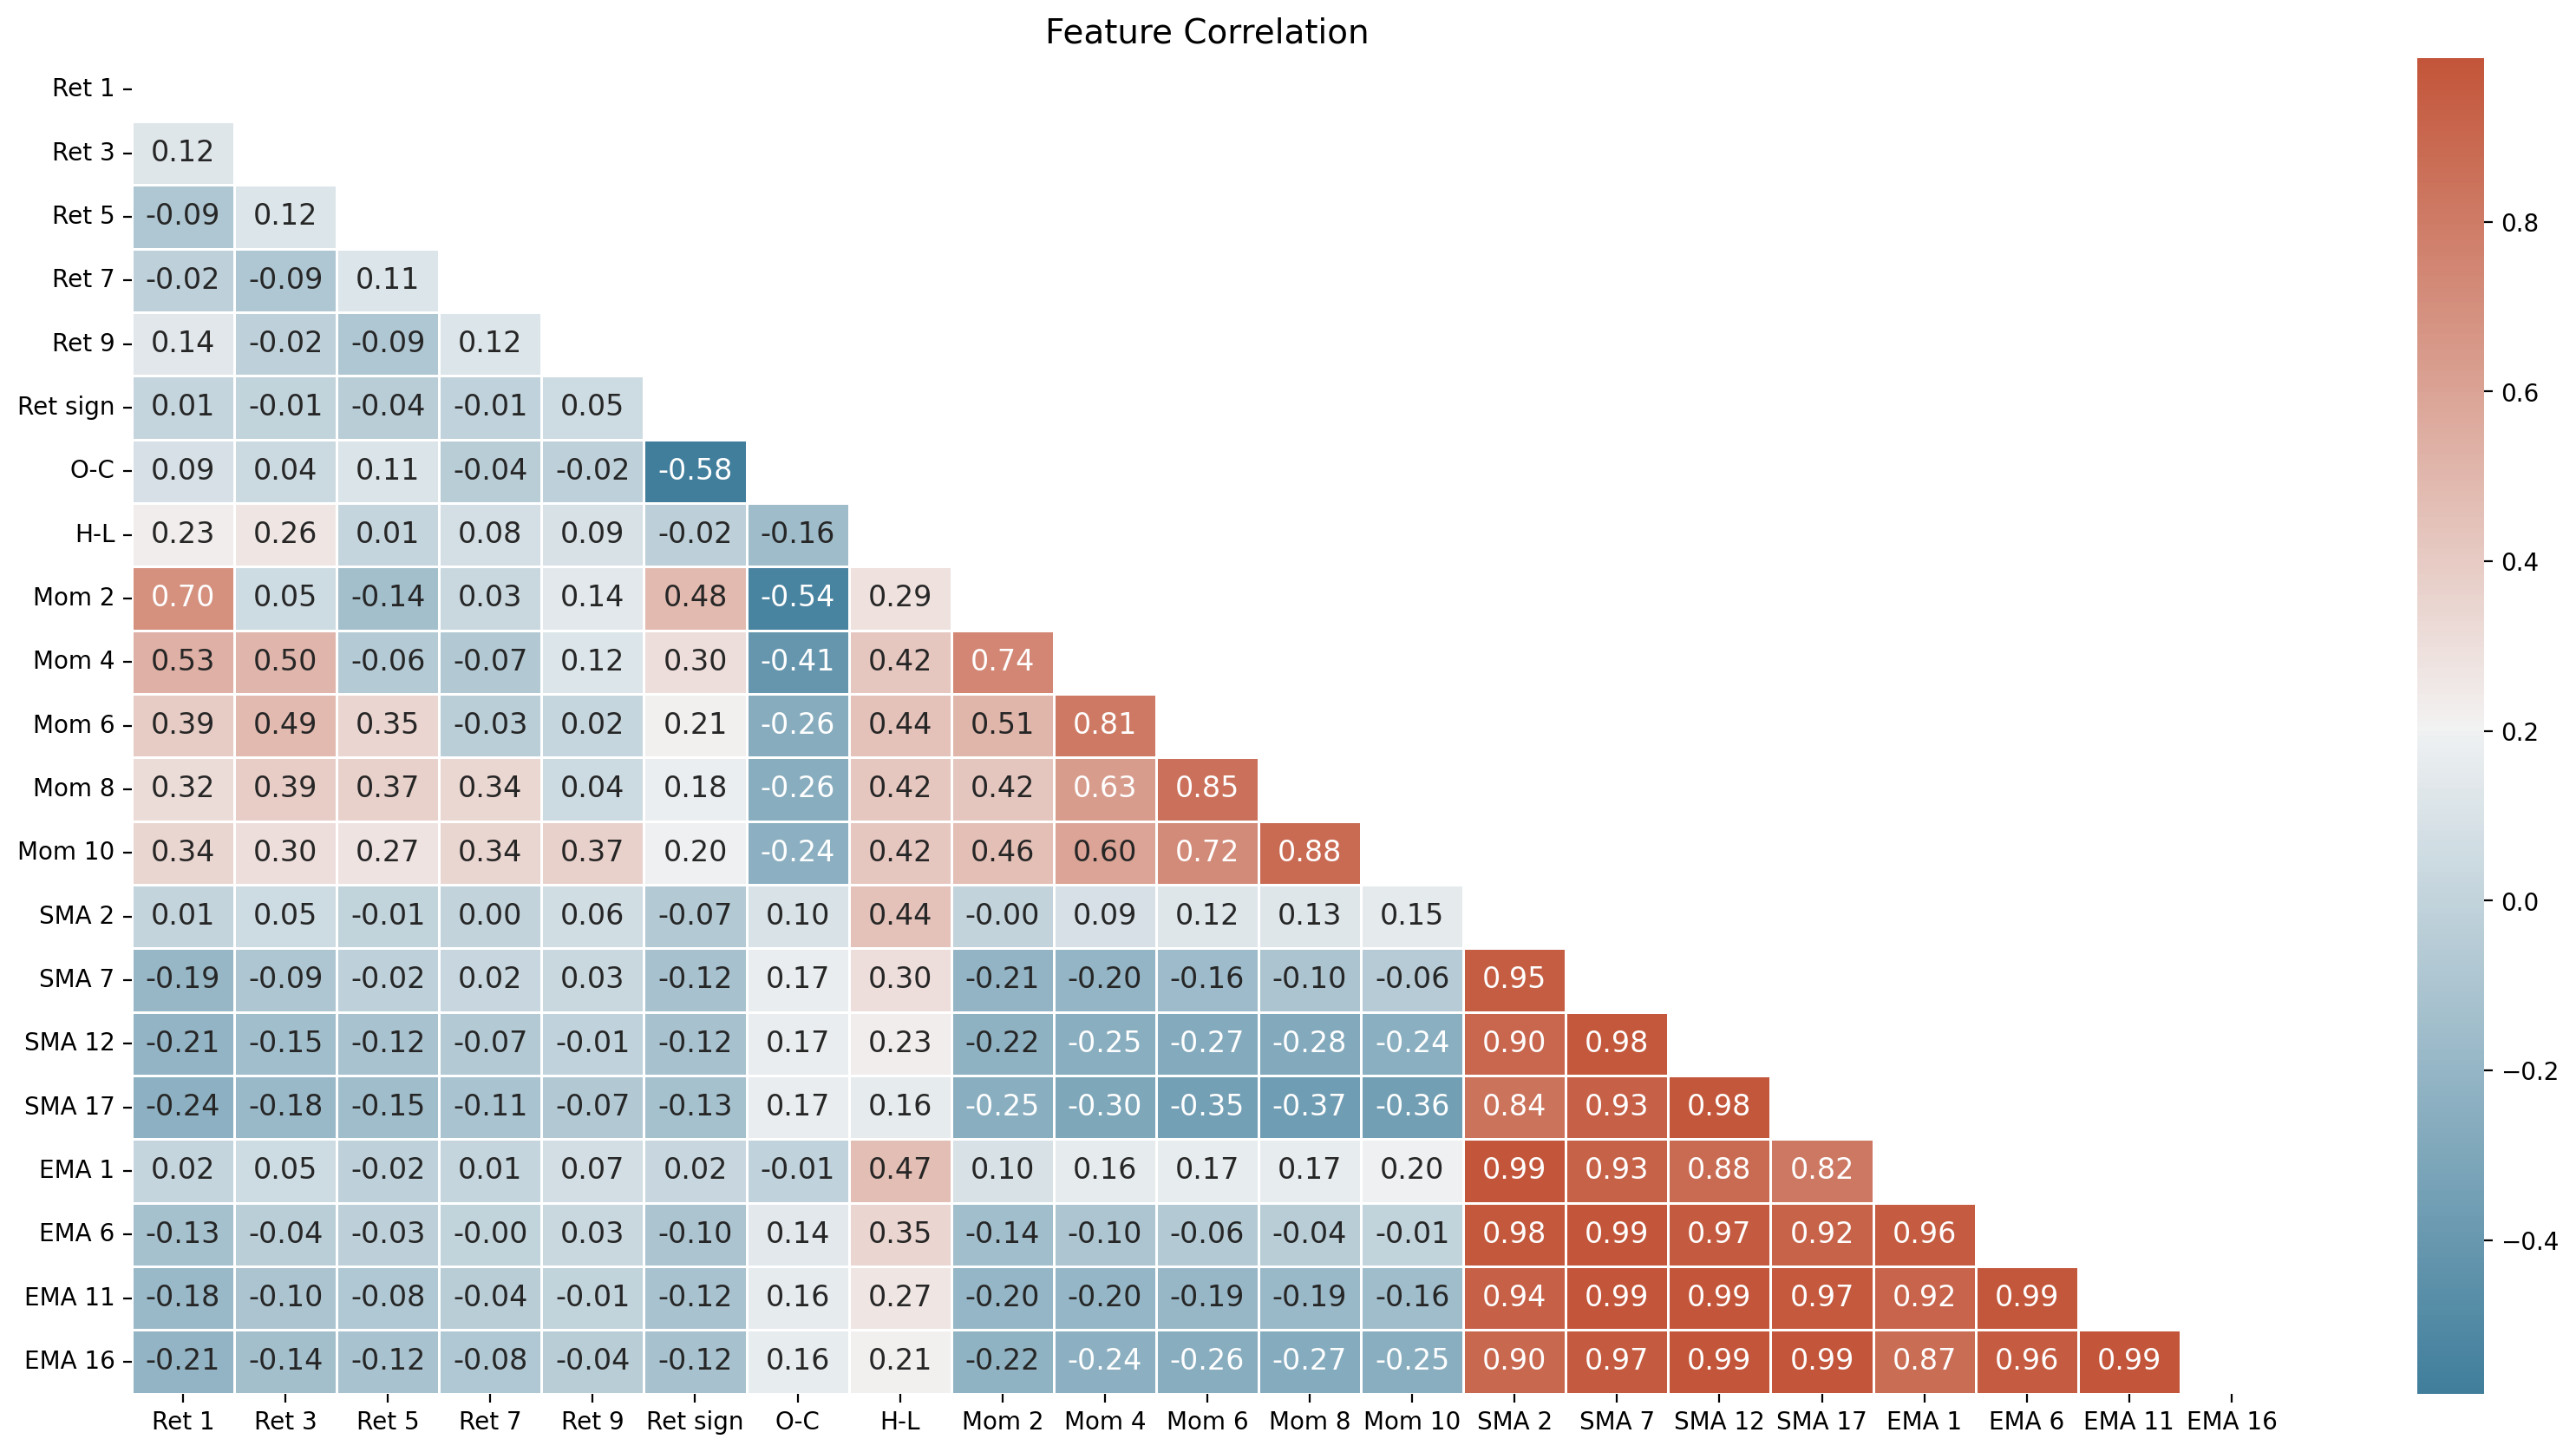

In [18]:
# Visualize feature correlation through a heatmap. We use the lower part of the matrix to avoid repetition of information. 


fig, ax=plt.subplots(figsize=(20,10))

mask = np.triu(np.ones_like(corrmat, dtype=bool))
cmap=sns.diverging_palette(230, 20, as_cmap=True)

sns.heatmap(corrmat, mask=mask,annot=True, annot_kws={'size': 12},fmt='0.2f',
            linewidths=0.5,square=False,cbar=True,cmap=cmap)
ax.set_title('Feature Correlation',fontsize=14,color='black')

## Scaling and splitting of data
We now discuss how scaling of the data is important in machine learning models. We focus on some possibly useful scalers and their relation with the data distribution. Then, we study if the assumption of Gaussianity of the various features has to be rejected. This will help us choose which scaler to use for this particular set of data. We divide the data into a train and validation set and apply the appropriate scaler.

###  Is scaling of data necessary?

When constructing a machine learning algorithm, feature scaling is one of the critical steps to consider for the building of a successful model. Appropriate feature scaling often makes the difference between a weak machine learning algorithm and a good one. \
Feature scaling allows the model to carry out an appropriate comparison of the data, which in turn leads to better predictions. Moreover, it prevents a feature with a large significant number to skew the model predictions and it allows for faster convergence of the model.

Many different kinds of feature scaling can be implemented, but the first question one should ask when building a machine learning algorithm is: "Is scaling really necessary?"\
The answer to the question is "YES!" whenever the algorithm will compute **distances between data** or **assumes normality**.

Given that this algorithm will employ regression models through $L_1$ and $L_2$ distances, scaling will be carried out.

Once one has decided to perform feature scaling, it is important to decide which scaling is the most appropriate for the model in question. 4 candidates will be considered for this exam:
- MinMax scaler: This scaler transforms each feature by scaling it in a given range: $$x_{scaled}=\frac{x-x_{min}}{x_{max}-x_{min}} $$ This scaler responds well if the standard deviation is small and when a distribution is not Gaussian. This scaler is sensitive to outliers.

- Standard scaler: This scaler assumes a normal distribution for the data with mean $\mu$ and variance $\sigma^2$, then scales it such that the mean is 0 and the variance 1 $$x_{scaled}=\frac{x-\mu}{\sigma}$$. Centring and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. If data is not normally distributed, this is not the best scaler to use.


- Robust scaler: If our data contains many outliers, scaling using the mean and standard deviation of the data won’t work well. The Robust scaler is a scaler that is particularly resistant to outliers. It works by removing the median and scales the data according to the quantile range specified. $$x_{scaled}\frac{x-Q_1(x)}{Q_3(x)-Q_1(x)}$$ The centring and scaling statistics of this method are based on percentiles and are therefore not influenced by a few numbers of huge marginal outliers. Outliers themselves are still present in the transformed data.


- PowerTransformer scaler: Power transforms are a family of parametric, monotonic transformations that are applied to make data more Gaussian-like. This is useful for modelling issues related to heteroscedasticity (non-constant variance), or other situations where normality is desired.

### Splitting Data into training and valuation sets

In [19]:
X=Features.values

In [20]:
# Need to equalise size of targets as len(y) is longer than len(X) due to the dropping of the NaN values. 
diff=len(y)-np.shape(X)[0]
for i in range(diff):
    y=np.delete(y,i)

In [21]:
# Split dataset into training and validation
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, shuffle=False)

### Feature preprocessing
As we precedently discussed, feature preprocessing is fundamental in order to get accurate results from the machine learning algorithm. The choice of scaler depends on the feature under consideration. 

Given the features considered so far in this exam, the choice of scalers are reported in the following table:

| Feature | Choice of Scaler | 
| --- | --- | 
| Sign of return | MinMaxScaler |
| O-C | MinMaxScaler |
|  H-L | MinMaxScaler |
| Lagged returns | PowerTransformer |
| Momentum | MinMaxScaler |
| SMA | MinMaxScaler |
| EMA | MinMaxScaler |

As it can be seen from the table, we used the PowerTransformer of the lagged returns because usually the assumption of the returns being normally distributed is common, and this scaler is therefore appropriate. 

The other quantities  are not expected to be normally distributed, hence we use a MinMaxScaler

With the use of **ColumnTransformer**, we define a transformer that applies the correct scaler to the appropriate feature.

In [22]:
# Use ColumnTranformer to scale different columns in the approriate way

normalisable=[0,1,2,3,4]
minmaxable=[5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20]
column_transf=ColumnTransformer([
    ('normaliser', PowerTransformer(method='yeo-johnson'),normalisable),
      ('MinMax ',MinMaxScaler(),minmaxable)])

In [23]:
# Here we scakle the test set for later, the scaler is fit on the train set to avoid information leaking

X_scaled=column_transf.fit_transform(X_train)  # this will be used later during feature selection

X_test_scaled=column_transf.transform(X_test) # this will be use for plotting the sigmoid functions
X_test_scaled[0,:]

array([ 0.02495237, -0.50363661,  0.92550885,  0.22737238,  0.1623612 ,
        0.        ,  0.67200748,  0.06365826,  0.31443305,  0.51006418,
        0.6178093 ,  0.51010309,  0.57016484,  0.54714951,  0.53849972,
        0.52710595,  0.5340519 ,  0.50864114,  0.55795238,  0.55970775,
        0.57331874])

In [24]:
X_test_scaled=column_transf.transform(X_test)
X_test_scaled[0,:]

array([ 0.02495237, -0.50363661,  0.92550885,  0.22737238,  0.1623612 ,
        0.        ,  0.67200748,  0.06365826,  0.31443305,  0.51006418,
        0.6178093 ,  0.51010309,  0.57016484,  0.54714951,  0.53849972,
        0.52710595,  0.5340519 ,  0.50864114,  0.55795238,  0.55970775,
        0.57331874])

# Part 2: Fitting logisitc regressions
We will proceed in the following order:

- We introduce and compare logistic Lasso and Ridge regression


- We fit Lasso and Ridge logistic regression


- We compare the impact made on regression coefficients by L1 and L2 penalisations


- We discuss bias and variance of Lasso and Ridge regression


- We plot the logistic sigmoids for the 3 largest weights feature of Ridge regression

## Introduction to LASSO and RIDGE models
The origin of Lasso and Ridge regression stems from the need of taming the impact of large coefficients in linear regression models. The process of limiting the impact of these coefficients is called *regularization* and allows to reduce overfitting problems.


Regularization is done through the imposition of a penalty to linear regression models. The type of penalty imposed to linear regression determines the name of the model:

- In **LASSO** regression the loss function is minimized by limiting the sum of absolute values of the model coefficients where the $L_1$ penalty term is added to the Mean Square Error (MSE) $$L=\frac{1}{n}\sum^n_{i=1}\left(y_i-w_0-\sum^p_{j=1}x_{ij}w_j \right)^2+\lambda\sum^p_{j=1}|w_j| $$


- In **RIDGE** regression the loss function (MSE) is supplemented by an $L_2$ penalty. The Ridge regression shrinks the coefficients and helps to reduce the multi-collinearity. $$L=\frac{1}{n}\sum^n_{i=1}\left(y_i-w_0-\sum^p_{j=1}x_{ij}w_j \right)^2+\lambda\sum^p_{j=1}w_j^2 $$

### A small note of logistic regression models
It is somehow questionable to use the MSE as a loss function for classification models like the one in this exam. Usually, log-penalisation is preferred for binary classification models due to its higher penalisation of wrong predictions and to the fact that it will always be a convex function in this kind of scenarios.


Therefore, for the purpose of this exam, we will refer to **LASSO** and **RIDGE** models as an $L_1$ or $L_2$ penalisation added to a log-loss function, which is more appropriate for binary classification  models.


We will achieve this using the LogistiRegression classifier. 

## LASSO logistic regression

In [25]:
# Define and fit LASSO logistic regression
# The optimal C parameter has been found through a grid search
pipeLasso = Pipeline([("column_transformer",column_transf),
                      ("classifier", LogisticRegression(penalty='l1',solver='liblinear',fit_intercept=True,C=0.752,random_state=None))]) 
A=pipeLasso.fit(X_train, y_train)

In [26]:
# Get parameters list
pipeLasso.get_params()

{'memory': None,
 'steps': [('column_transformer',
   ColumnTransformer(transformers=[('normaliser', PowerTransformer(),
                                    [0, 1, 2, 3, 4]),
                                   ('MinMax ', MinMaxScaler(),
                                    [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                     18, 19, 20])])),
  ('classifier',
   LogisticRegression(C=0.752, penalty='l1', solver='liblinear'))],
 'verbose': False,
 'column_transformer': ColumnTransformer(transformers=[('normaliser', PowerTransformer(),
                                  [0, 1, 2, 3, 4]),
                                 ('MinMax ', MinMaxScaler(),
                                  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                   18, 19, 20])]),
 'classifier': LogisticRegression(C=0.752, penalty='l1', solver='liblinear'),
 'column_transformer__n_jobs': None,
 'column_transformer__remainder': 'drop',
 'column_transformer__spars

In [27]:
# Perform Gridsearch and fit
param_grid = {'classifier__C': np.arange(0.002,15,0.05)}

grid_search = GridSearchCV(pipeLasso, param_grid, scoring='roc_auc', n_jobs=-1, cv=None, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('normaliser',
                                                                         PowerTransformer(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('MinMax ',
                                                                         MinMaxScaler(),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20])])),
                                       ('classifier',
                                        LogisticRegression(C=0.752,
                                                           penalty='l1',
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([2.0000e-03, 5.20...
       1.3502e+01, 1.3552e+01, 1.3602e+01, 1.3652e+01, 1.3702e+01,
       1.3752e+01, 1.3802e+01, 1.3852e+01, 1.3902e+01, 1.3952e+01,
       1.4002e+01, 1.4052e+01, 1.4102e+01, 1.4152e+01, 1.4202e+01,
       1.4252e+01, 1.4302e+01, 1.4352e+01, 1.4402e+01, 1.4452e+01,
       1.4502e+01, 1.4552e+01, 1.4602e+01, 1.4652e+01, 1.4702e+01,
       1.4752e+01, 1.4802e+01, 1.4852e+01, 1.4902e+01, 1.4952e+01])},
             scoring='roc_auc', verbose=1)

In [28]:
# Best Params
grid_search.best_params_

{'classifier__C': 0.752}

In [29]:
# Weights set by the Lasso regression
pipeLasso['classifier'].coef_.flatten()

array([-0.00269866, -0.10426766,  0.13683147,  0.04115378, -0.03763106,
        0.39502963,  0.        , -0.43873588,  0.        ,  0.        ,
        0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
        0.        , -0.37983806,  0.        ,  0.        ,  0.        ,
        0.        ])

In [30]:
# Intercept of the Lasso regression
pipeLasso['classifier'].intercept_

array([0.])

In [31]:
# Lasso coefficient as a function of the regularization

C_lasso_range = np.linspace(0.01,50,100)
lasso_coef = []

for i in C_lasso_range:
    lasso = Pipeline([("column_transformer",column_transf),
                      ("classifier", LogisticRegression(penalty='l1',solver='liblinear',max_iter=1000,C=i,random_state=None))]) 
    lasso.fit(X_train, y_train)
    lasso_coef.append(lasso['classifier'].coef_.flatten())

In [32]:
# Plot of lasso coefficient as a function of the regularization
def plot_coeff(C_range, coef, modelname):
    
    # Plot Coefficients
    fig = plt.figure(figsize=(20,8))
    ax = plt.axes()
    
    ax.plot(C_range, coef)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    ax.set_title(f'{modelname} coefficients as a function of the regularization')
    ax.set_xlabel('$C$')
    ax.set_ylabel('Weights')
    

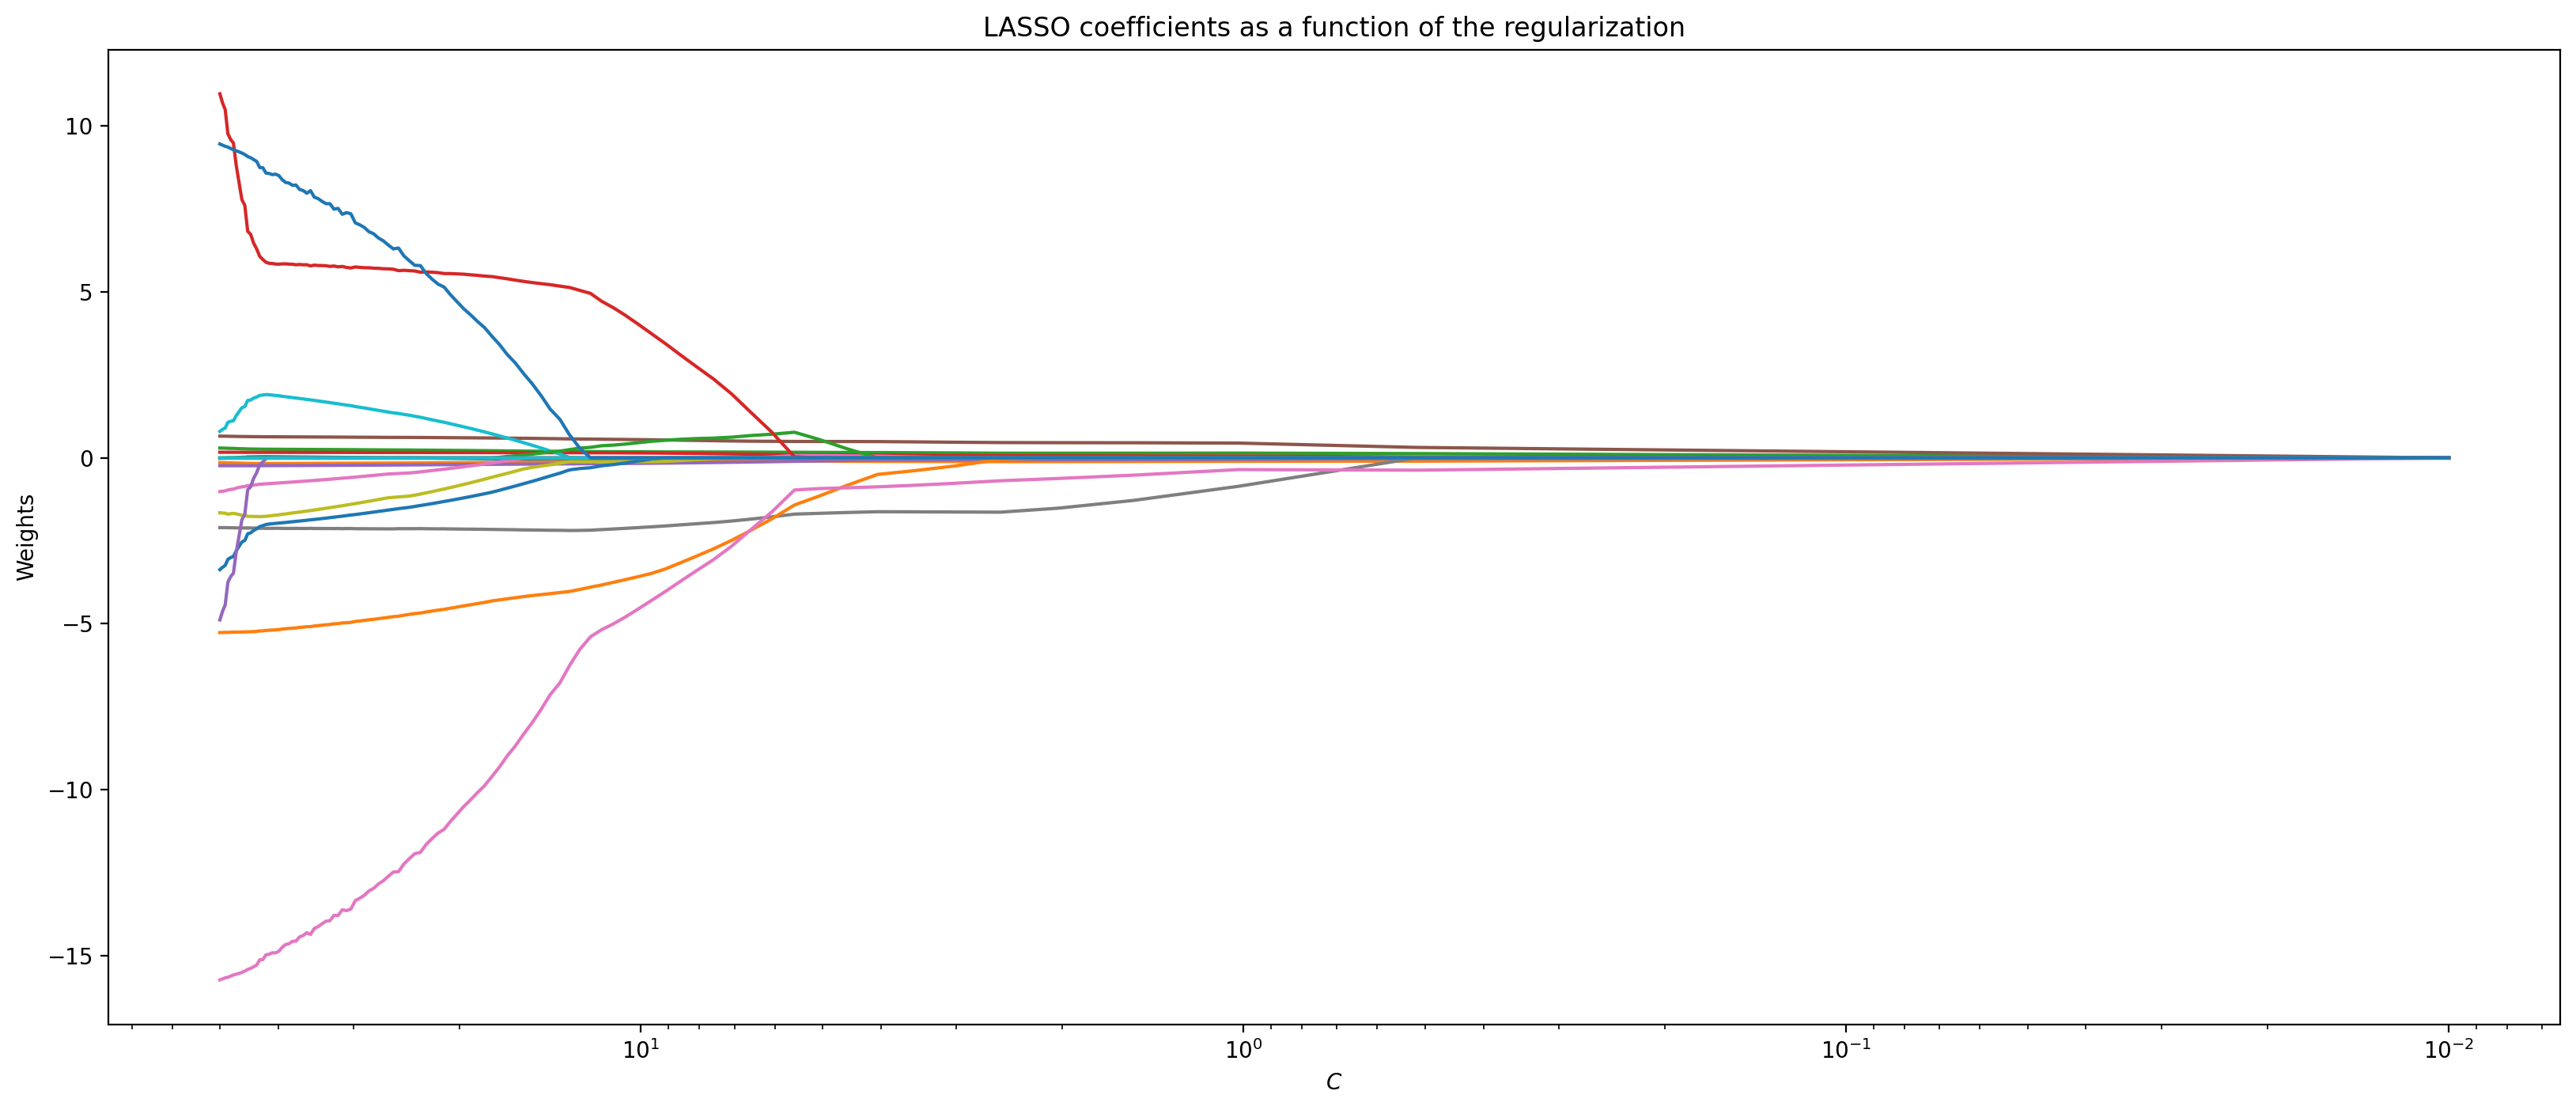

In [33]:
# Plot Coefficients
plot_coeff(C_lasso_range, lasso_coef, 'LASSO')

## RIDGE logistic regression

In [34]:
# Define and fit Ridge Logistic regression
# The optimal C parameter has been found through a grid search
pipeRidge = Pipeline([("column_transformer",column_transf),
                      ("classifier", LogisticRegression(penalty='l2',solver='lbfgs',max_iter=200,C=0.15200000000000002,random_state=None))]) 
pipeRidge.fit(X_train, y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('normaliser',
                                                  PowerTransformer(),
                                                  [0, 1, 2, 3, 4]),
                                                 ('MinMax ', MinMaxScaler(),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20])])),
                ('classifier',
                 LogisticRegression(C=0.15200000000000002, max_iter=200))])

In [35]:
# Get parameters list
pipeRidge.get_params()

{'memory': None,
 'steps': [('column_transformer',
   ColumnTransformer(transformers=[('normaliser', PowerTransformer(),
                                    [0, 1, 2, 3, 4]),
                                   ('MinMax ', MinMaxScaler(),
                                    [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                     18, 19, 20])])),
  ('classifier', LogisticRegression(C=0.15200000000000002, max_iter=200))],
 'verbose': False,
 'column_transformer': ColumnTransformer(transformers=[('normaliser', PowerTransformer(),
                                  [0, 1, 2, 3, 4]),
                                 ('MinMax ', MinMaxScaler(),
                                  [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17,
                                   18, 19, 20])]),
 'classifier': LogisticRegression(C=0.15200000000000002, max_iter=200),
 'column_transformer__n_jobs': None,
 'column_transformer__remainder': 'drop',
 'column_transformer__sparse_threshold': 0

In [36]:
# Perform Gridsearch and fit
param_grid = {'classifier__C': np.arange(0.002,15,0.05)}

grid_search = GridSearchCV(pipeRidge, param_grid, scoring='roc_auc', n_jobs=-1, cv=None, verbose=1)
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('normaliser',
                                                                         PowerTransformer(),
                                                                         [0, 1,
                                                                          2, 3,
                                                                          4]),
                                                                        ('MinMax ',
                                                                         MinMaxScaler(),
                                                                         [5, 6,
                                                                          7, 8,
                                                                          9, 10,
                                                                          11,
                                                                          12,
                                                                          13,
                                                                          14,
                                                                          15,
                                                                          16,
                                                                          17,
                                                                          18,
                                                                          19,
                                                                          20])])),
                                       ('classifier',
                                        LogisticRegression(C=0.15200000000000002,
                                                           max_iter=200))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([2.0000e-03, 5.2000e-0...
       1.3502e+01, 1.3552e+01, 1.3602e+01, 1.3652e+01, 1.3702e+01,
       1.3752e+01, 1.3802e+01, 1.3852e+01, 1.3902e+01, 1.3952e+01,
       1.4002e+01, 1.4052e+01, 1.4102e+01, 1.4152e+01, 1.4202e+01,
       1.4252e+01, 1.4302e+01, 1.4352e+01, 1.4402e+01, 1.4452e+01,
       1.4502e+01, 1.4552e+01, 1.4602e+01, 1.4652e+01, 1.4702e+01,
       1.4752e+01, 1.4802e+01, 1.4852e+01, 1.4902e+01, 1.4952e+01])},
             scoring='roc_auc', verbose=1)

In [37]:
# Best Params
grid_search.best_params_

{'classifier__C': 0.15200000000000002}

In [38]:
# Weights set by the Ridge regression
pipeRidge['classifier'].coef_.flatten()

array([-0.02495598, -0.10753575,  0.14262995,  0.0632477 , -0.05152103,
        0.31795957,  0.00112698, -0.18141108, -0.03166286, -0.02976401,
       -0.08114546, -0.09667536, -0.02080154, -0.11188898, -0.10164629,
       -0.09743219, -0.14532755, -0.11122805, -0.1118862 , -0.11565656,
       -0.12018628])

In [39]:
# Intercept of the Ridge regression
pipeRidge['classifier'].intercept_

array([0.41975411])

In [40]:
# Ridge coefficient as a function of the regularization

C_ridge_range = np.linspace(0.001,40,100)
ridge_coef = []

for i in C_ridge_range:
    ridge = Pipeline([("column_transformer",column_transf),
                      ("classifier", LogisticRegression(penalty='l2',solver='lbfgs',max_iter=200,C=i,random_state=None))])
    ridge.fit(X_train, y_train)
    ridge_coef.append(ridge['classifier'].coef_.flatten())

In [41]:
# Plot of Ridge coefficient as a function of the regularization

def plot_coeff(C_range, coef, modelname):
    
    # Plot Coefficients
    fig = plt.figure(figsize=(20,8))
    ax = plt.axes()
    
    ax.plot(C_range, coef)
    ax.set_xscale('log')
    ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
    ax.set_title(f'{modelname} coefficients as a function of the regularization')
    ax.set_xlabel('$C$')
    ax.set_ylabel('Weights')
    

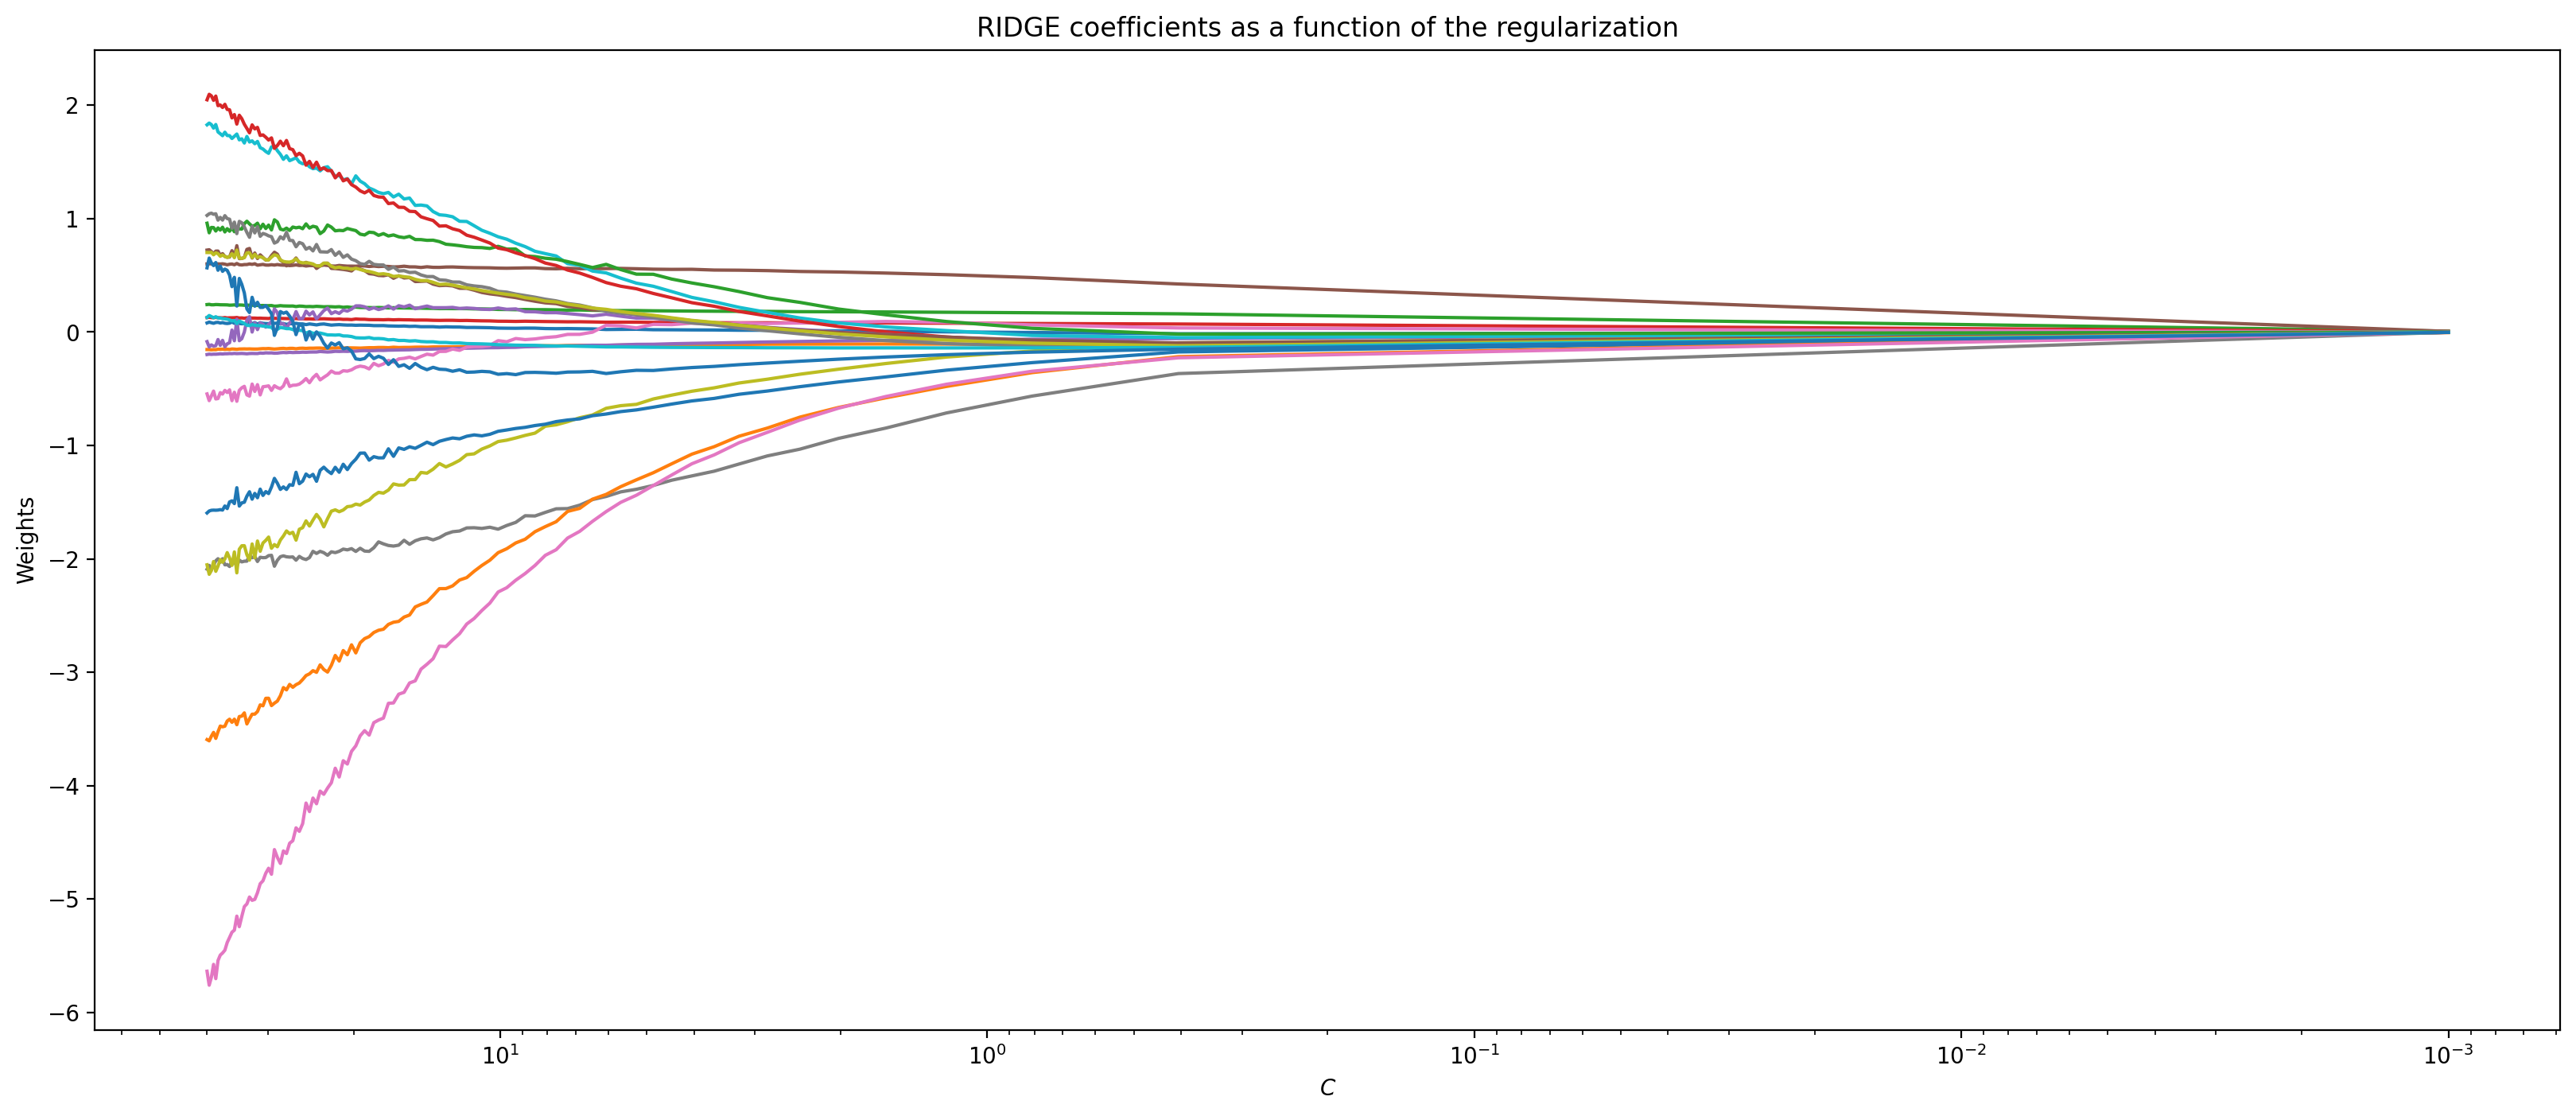

In [42]:
# Plot Coefficients
plot_coeff(C_ridge_range, ridge_coef, 'RIDGE')

## Bias and Variance of Lasso and Ridge regression
In every regression model we can identify two kinds of error that are linked by a tradeoff:

- **Bias**: The bias is an error from erroneous assumptions in the learning algorithm. It refers to how far away the estimated values are from the true values. High bias can cause an algorithm to miss the relevant relations between features and target outputs (underfitting).


- **Variance**: The variance is an error from sensitivity to small fluctuations in the training set. It is a measure of spread or variations in our predictions. High variance can cause an algorithm to model the random noise in the training data, rather than the intended outputs (overfitting).

These two quantities are tied by a fundamental tradeoff. If the variance is increased/decreased the bias will decrease/increase.

Both Lasso and Ridge regression are shrinkage methods, and their regularization penalizes high values of the coefficients which in turn reduces the mean squared error and predicted error. This penalty is not applied to the intercept of the regression, meaning that both methods trade a **decrease in variance** for an **increase in bias**.

### Sigmoid plotting for feature winning by largest coefficient
We find the three features winning by largest coefficient in Ridge regression and plot the associated sigmoid function

In [43]:
# Sorting the weights of Ridge regression to find the largest
sorted_ridge_coeff=sorted(pipeRidge['classifier'].coef_.flatten(),reverse=True)
sorted_ridge_coeff[:3]

[0.3179595718329223, 0.14262994941370719, 0.06324770122559976]

In [44]:
# Save intercept into variable
intercept=pipeRidge['classifier'].intercept_
intercept

array([0.41975411])

In [45]:
# Find columns of the train set associated with largest 3 coefficients

index=np.zeros(3)
for k in range(3):
    for i in range(21):
        if sorted_ridge_coeff[k]==np.abs(pipeRidge['classifier'].coef_.flatten()[i]):
            index[k]=i
index

array([5., 2., 3.])

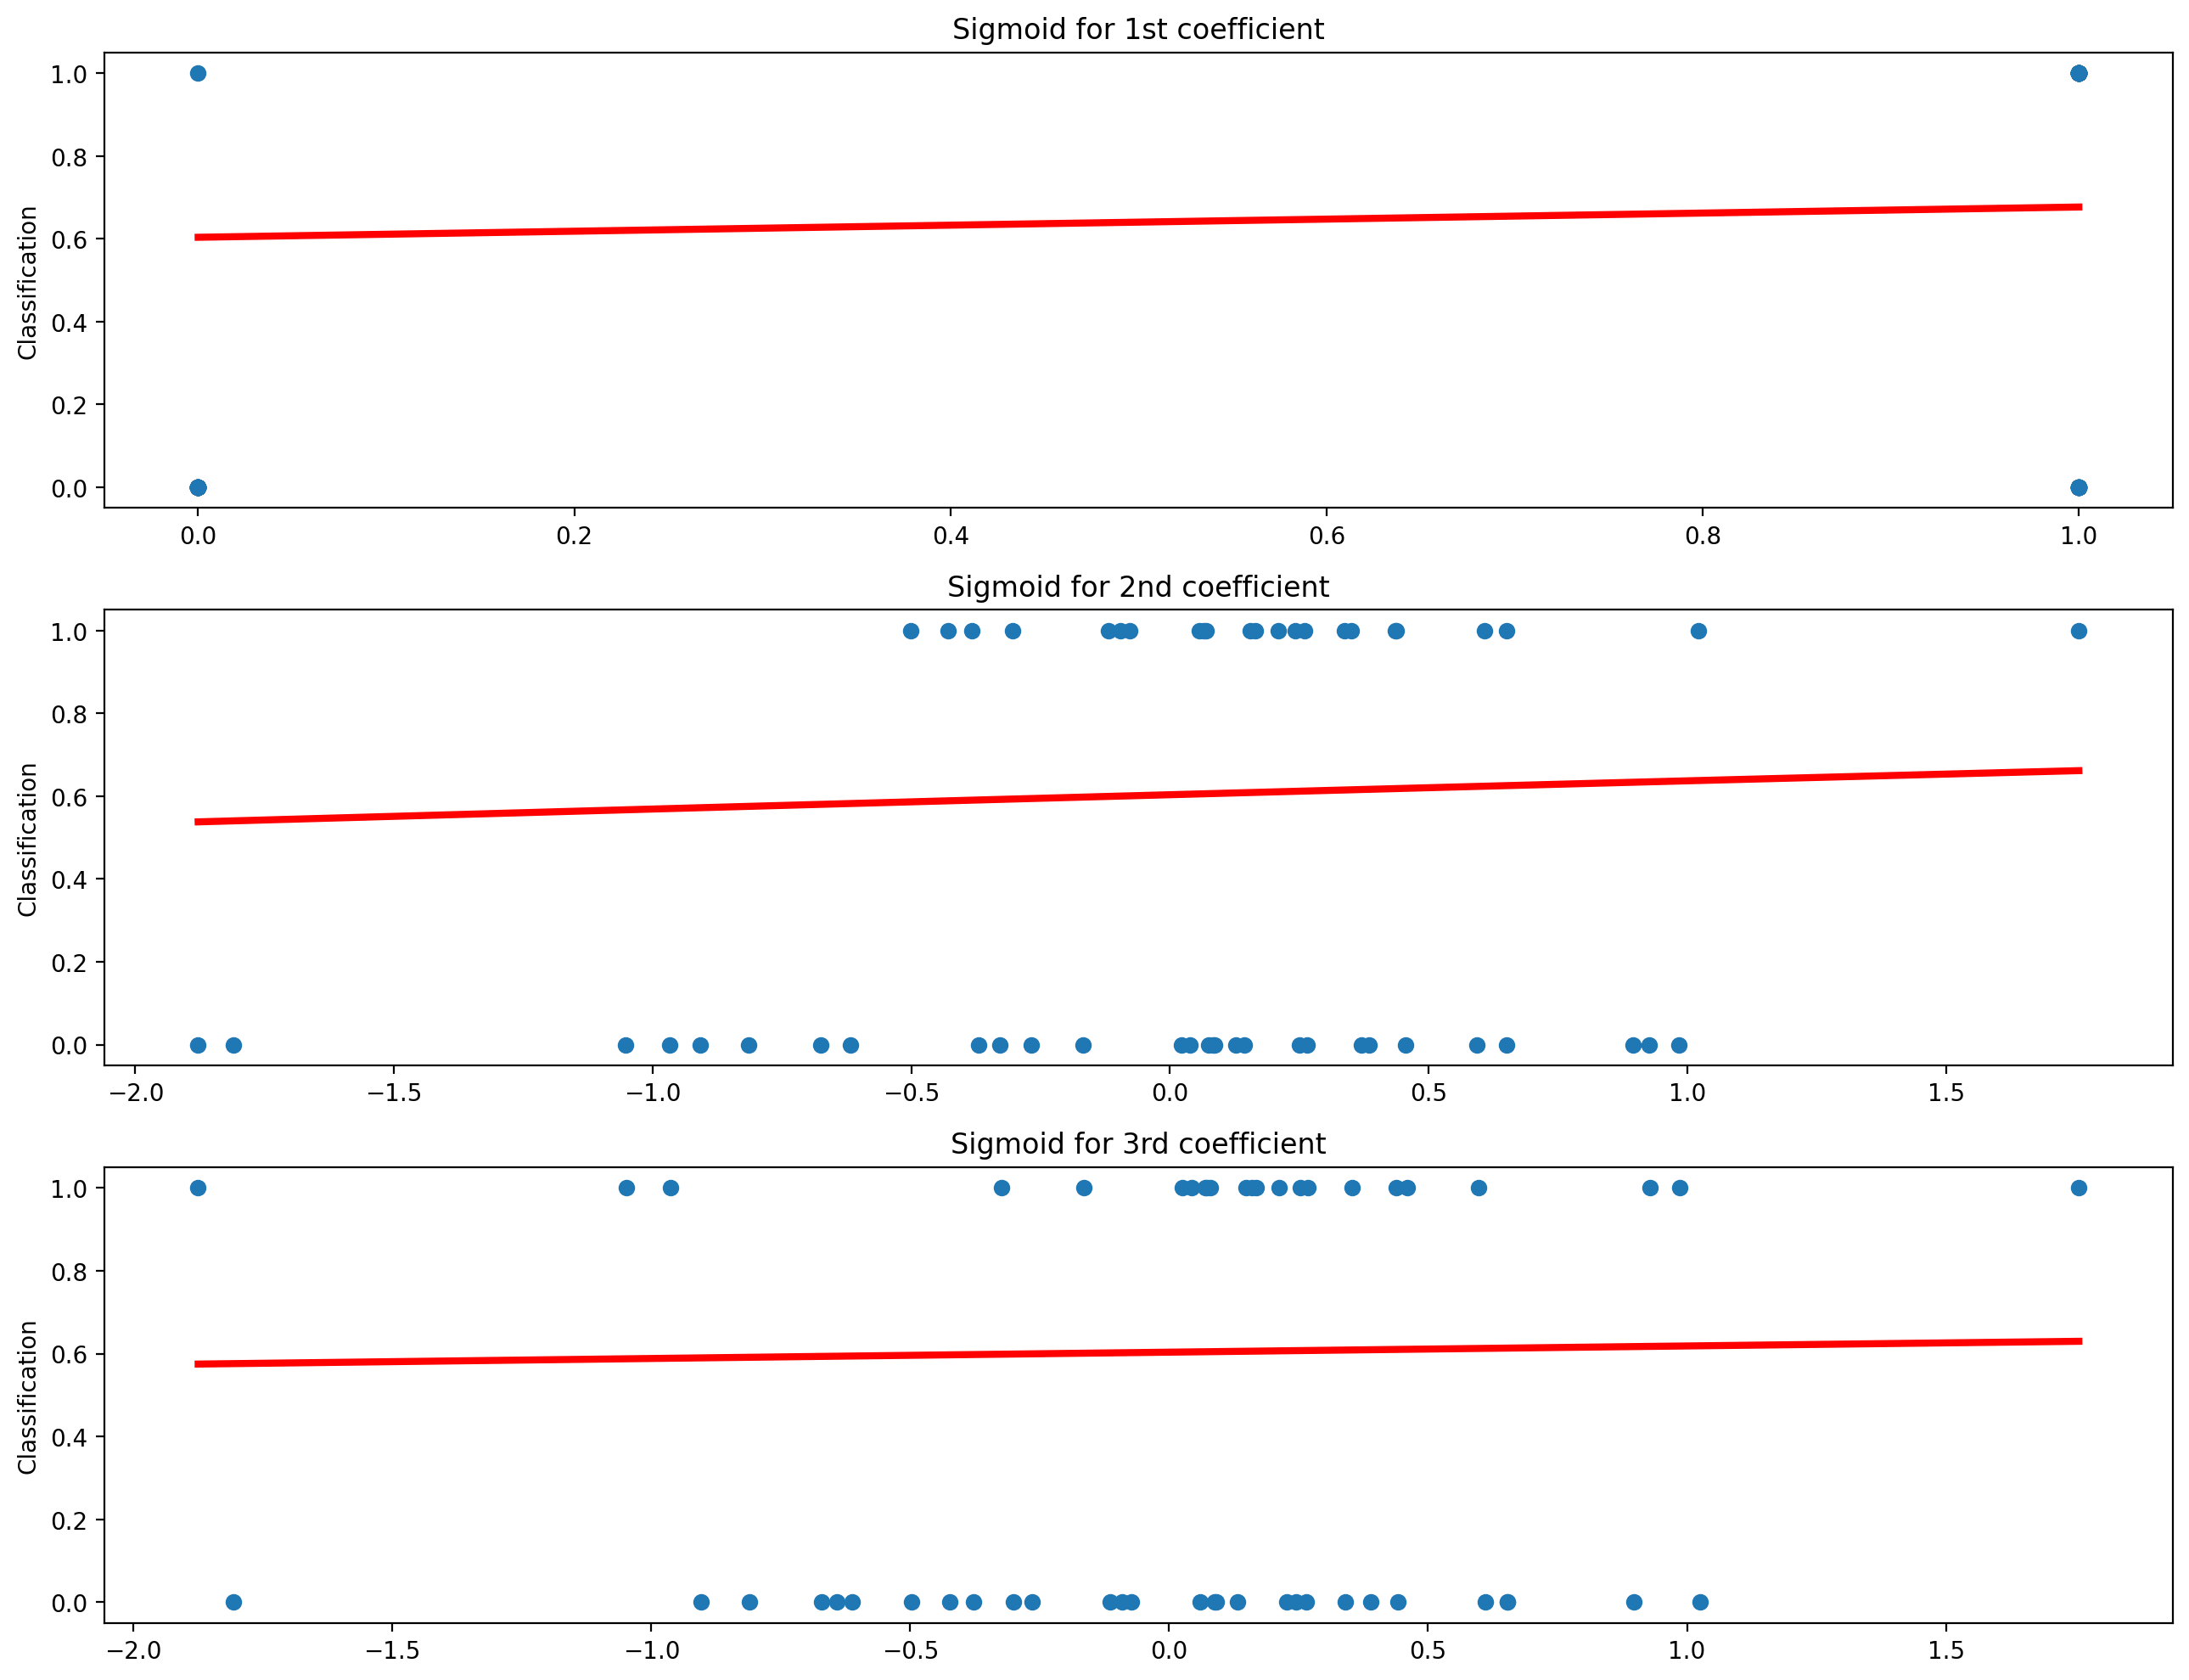

In [46]:
# Plotting of Logistic Sigmoid for 3 features winning by largest coefficient 

fig, axes=plt.subplots(3,1, figsize=(13, 10))
axes=axes.ravel()
ordinal=['st','nd','rd']  # this is needed to write the title of plots properly

for k in range(3):
    axes[k].scatter(X_test_scaled[:,int(index[k])], pipeRidge.predict(X_test))
    loss = expit(np.sort(X_test_scaled[:,int(index[k])])*sorted_ridge_coeff[k]+intercept )
    axes[k].plot(np.sort(X_test_scaled[:,int(index[k])]), loss, color="red", linewidth=3)
    axes[k].set_title('Sigmoid for %d' %(k+1) +ordinal[k]+' coefficient')
    axes[k].set_ylabel('Classification')
fig.tight_layout()
plt.show()

### A comment on the logistic plots
The second logistic plot is associated with one of the moving averages. Being that the moving averages are always positive, but the intercept is computed over with the fitting of all features, the plot of the sigmoid associated with this function does not look very sigmoid-like.

# Part III: Feature scoring and elimination
In this section we perform feature selection using the sklearn package. This will allow us to decide which eatures to keep in the final model. We will proceed in the following order:


- We discuss feature selection and the key property of the chosen approaches


- We perform feature selection and analyse the results of the different approaches


- We plot the logistic sigmoid for the winning 3/4 features

## Introduction to feature selection 
When constructing a machine learning model we often end up with a wide choice of predictors. Some of these predictors may be correlated with each other in such a way that using them together would not actually provide more information to the algorithm and will only have the effect of slowing the whole process down. This is where the process of feature scoring and elimination becomes relevant.

Feature scoring consists in analysing the predictors and ranking them in order according to how much information they convey. Feature elimination then consists in making a selection of these predictors in such a way that those which are redundant are eliminated, while the ones conveying the most information are kept.

There are many ways in which feature scoring and elimination can be performed. We will use the following 3:

- **Variance Inflation Factor**: VIF is the ratio of the variance of estimating some parameter in a model that includes multiple other parameters by the variance of a model constructed using only one term. It quantifies the severity of multicollinearity and provides an index that measures how much the variance (the square of the estimate's standard deviation) of an estimated regression coefficient is increased because of collinearity. The VIF factor for the i-th feature is calculated as  $$VIF_i=\frac{1}{1-R_i^2}$$ where $R^2_i$ is the coefficient of determination of the regression equation for that feature regressed against the others


- **Recursive Feature Elimination**: RFE is a wrapper-type feature selection algorithm. This means that a different machine learning algorithm is given and used in the core of the method, is wrapped by RFE, and used to help select features. RFE works by searching for a subset of features by starting with all features in the training dataset and successfully removing features until the desired number remains. Features are scored either using the provided machine learning model (e.g. some algorithms like decision trees offer importance scores) or by using a statistical method. This is achieved by fitting the given machine learning algorithm used in the core of the model, ranking features by importance, discarding the least important features, and re-fitting the model. This process is repeated until a specified number of features remains.


- **SHapley Additive exPlanations**: Shapley values are a widely used approach from cooperative game theory that come with desirable properties. To understand a feature’s importance in a model it is necessary to understand both how changing that feature impacts the model’s output, and also the distribution of that feature’s values. The core idea behind Shapley value-based explanations of machine learning models is to use fair allocation results from cooperative game theory to allocate credit for a model’s output among its input features. In order to connect game theory with machine learning models, it is necessary to both match a model’s input features with players in a game, and also match the model function with the rules of the game. Since in Game Theory a player can join or not join a game, we need a way for a feature to “join” or “not join” a model. The most common way to define what it means for a feature to “join” a model is to say that feature has “joined a model” when we know the value of that feature, and it has not joined a model when we don’t know the value of that feature. One of the fundamental properties of Shapley values is that they always sum up to the difference between the game outcome when all players are present and the game outcome when no players are present. For machine learning models this means that SHAP values of all the input features will always sum up to the difference between baseline (expected) model output and the current model output for the prediction being explained. 

### Variance Inflation Factor

In [47]:
# For each X, caluclate VIF and save into dataframe

vif=pd.DataFrame()
vif['Features']=Features.columns
vif['VIF Factor']=np.around([variance_inflation_factor(X_scaled,i) for i in range(X_scaled.shape[1])])
vif.sort_values(by=['VIF Factor'])

,Features,VIF Factor
4,Ret 9,3.0
3,Ret 7,4.0
5,Ret sign,4.0
7,H-L,4.0
2,Ret 5,7.0
1,Ret 3,8.0
0,Ret 1,13.0
6,O-C,138.0
9,Mom 4,674.0
11,Mom 8,701.0


The feature selected with this approach are the **Ret 9, Ret 7, Ret sign and H-L**

In [48]:
# We will keep features with an index up to 4
X_train_VIF=np.zeros([len(y_train),4])
i=0
select=np.array([4,3,5,7])

for k in select:
    X_train_VIF[:,i]=X_train[:,k]
    i=i+1

### Recursive Feature Elimination

In [49]:
felim3=RFE(LogisticRegression(penalty='l2',solver='lbfgs',max_iter=200,C=0.15200000000000002,random_state=None),n_features_to_select=5, step=1)
felim3.fit(X_scaled,y_train)

RFE(estimator=LogisticRegression(C=0.15200000000000002, max_iter=200),
    n_features_to_select=5)

In [50]:
# Check the selected position
felim3.support_

array([False, False, False, False, False,  True, False,  True, False,
       False, False, False, False,  True, False, False,  True,  True,
       False, False, False])

In [51]:
# Get the feature ranking
felim3.ranking_

array([15,  6,  3, 11, 12,  1, 17,  1, 13, 14,  8, 10, 16,  1,  7,  9,  1,
        1,  2,  4,  5])

In [52]:
# Select 3 Features
min_value = min(felim3.ranking_)
col = [i for i, x in enumerate(felim3.ranking_) if x == min_value]
col

[5, 7, 13, 16, 17]

In [53]:
# The features selected by the models are
print('The features selected by the models are: ',Features.columns[5],', ',Features.columns[7],', ',Features.columns[13],', ',Features.columns[16],', ',Features.columns[17])

The features selected by the models are:  Ret sign ,  H-L ,  SMA 2 ,  SMA 17 ,  EMA 1


### SHAP

In [54]:
# 100 instances for use as the background distribution
X100 = shap.utils.sample(Features.iloc[:204,:], 100, random_state=69)
pipeRidge.fit(Features.iloc[:204,:], y_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('normaliser',
                                                  PowerTransformer(),
                                                  [0, 1, 2, 3, 4]),
                                                 ('MinMax ', MinMaxScaler(),
                                                  [5, 6, 7, 8, 9, 10, 11, 12,
                                                   13, 14, 15, 16, 17, 18, 19,
                                                   20])])),
                ('classifier',
                 LogisticRegression(C=0.15200000000000002, max_iter=200))])

In [55]:
# compute the SHAP values for the linear model
explainer = shap.Explainer(pipeRidge.predict, X100)
shap_values = explainer(Features.iloc[:204,:])

PermutationExplainer explainer: 205it [00:15,  6.04it/s]                         


The beeswarm plot is designed to display an information-dense summary of how the top features in a dataset impact the model’s output. In each instance, the given explanation is represented by a single dot on each feature row. The x position of the dot is determined by the SHAP value of that feature, and the dots “pile-up” along each feature row to show density. Colour is used to display the original value of a feature

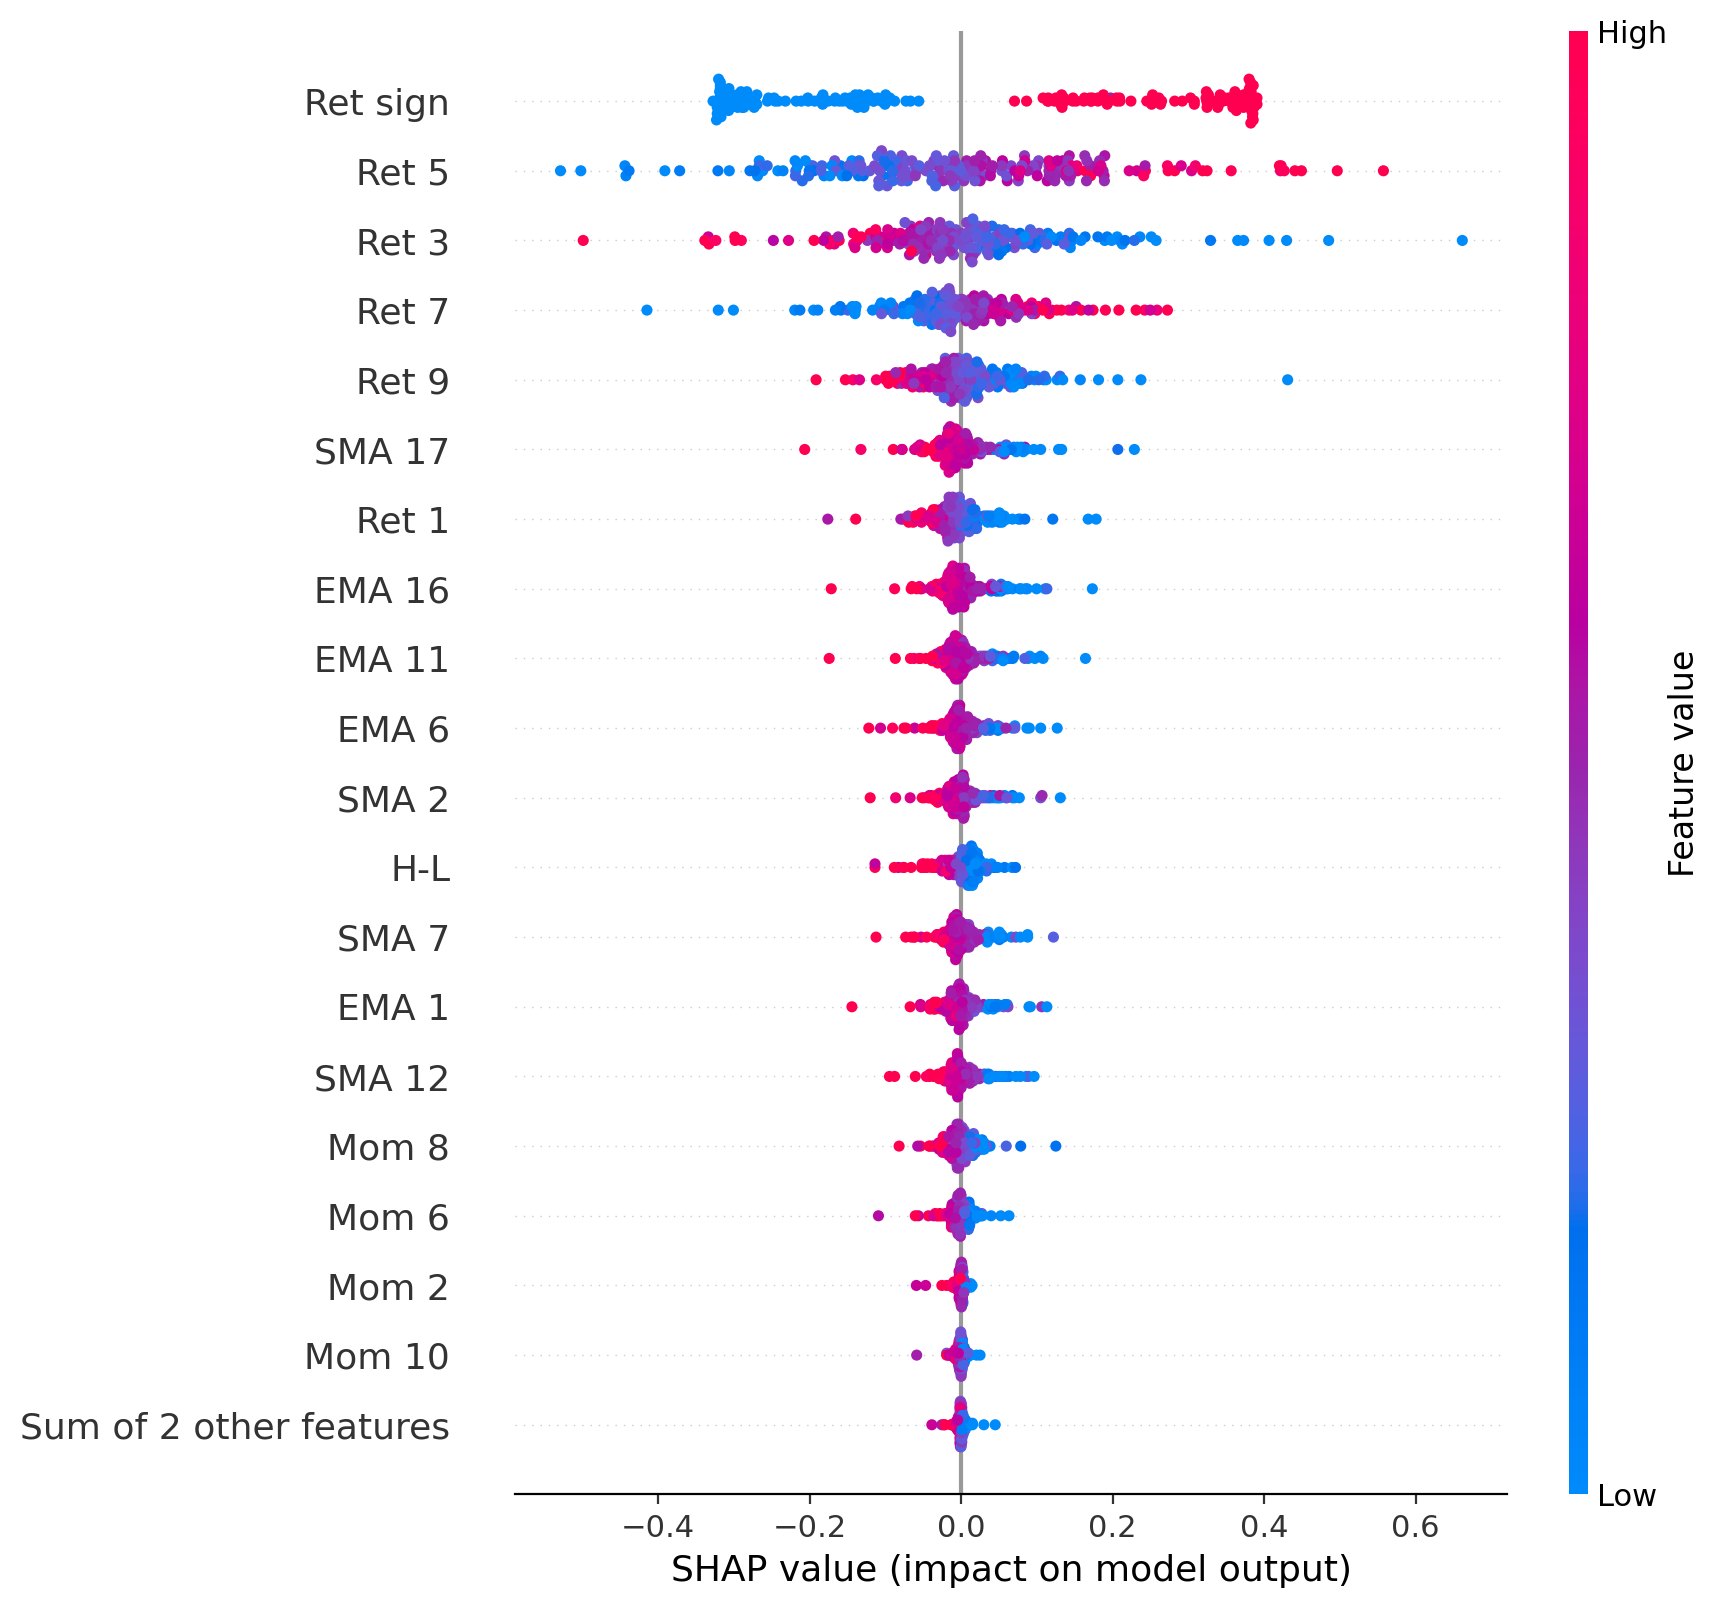

In [56]:
shap.plots.beeswarm(shap_values, max_display=20)

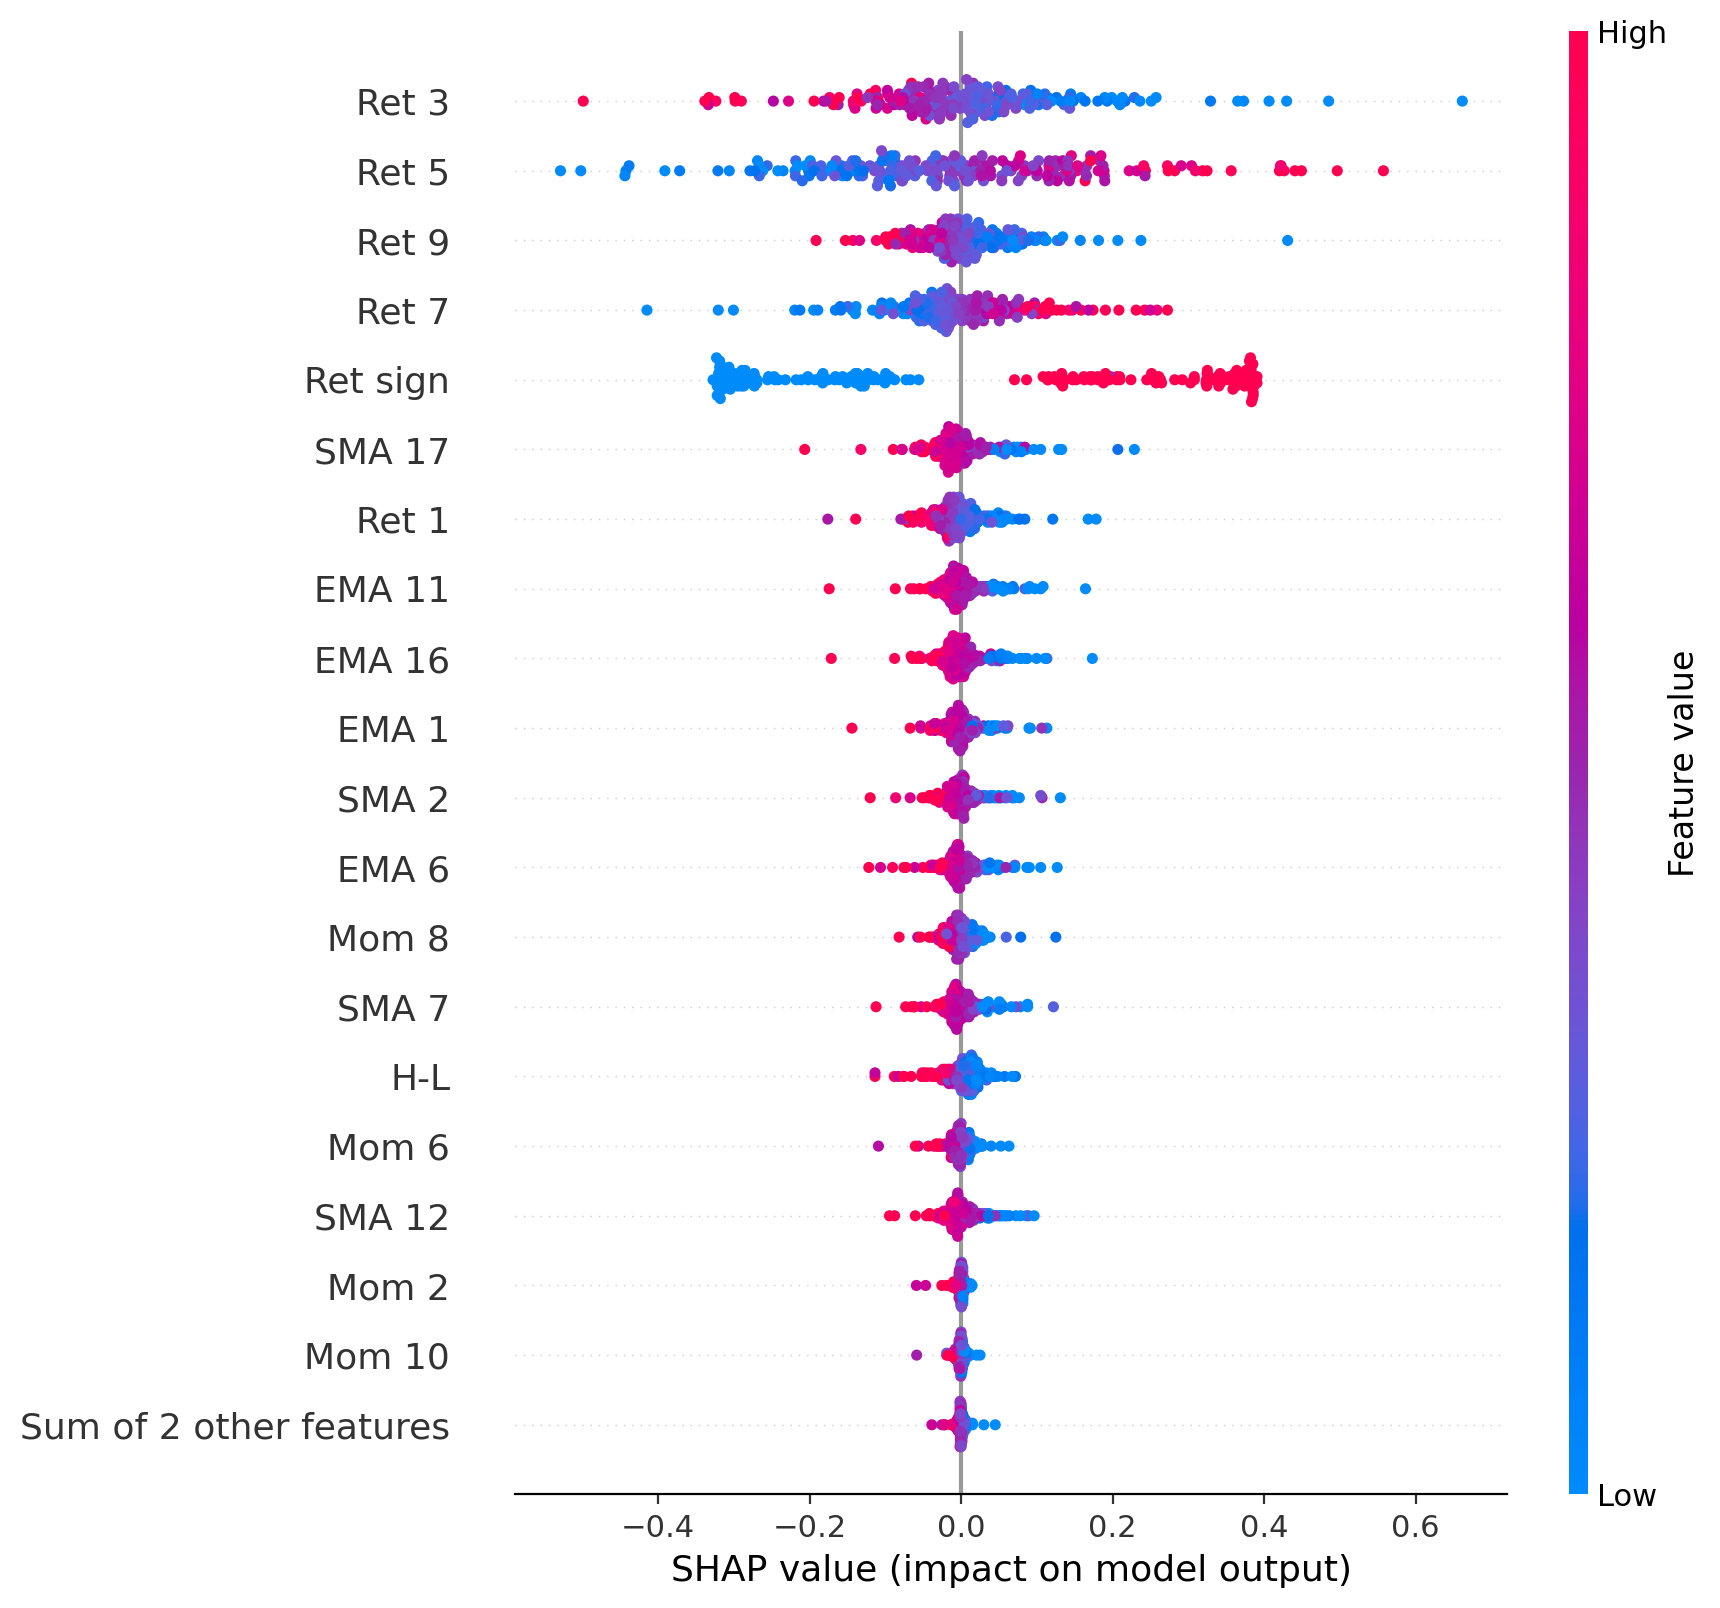

In [57]:
shap.plots.beeswarm(shap_values, max_display=20,order=shap_values.abs.max(0))

The relevant features according to the SHAP selection are: 
- Ret 3
- Ret Sign
- Ret 5
- Ret 9
- Ret 7

### Table of relevant feature and feature selection
|**VIF**|**RFE**|**SHAP**|
|---|---|---|
|Ret 9|Ret sign|Ret 3|
|Ret 7|H-L|Ret Sign|
|Ret sign|SMA 2|Ret 5|
|H-L|SMA 17|Ret 9|
|Ret 5|EMA 1|Ret 7|

We choose **Ret 3**, **Ret 5**, **Ret 9** and **Ret sign** as the relevant features for the model

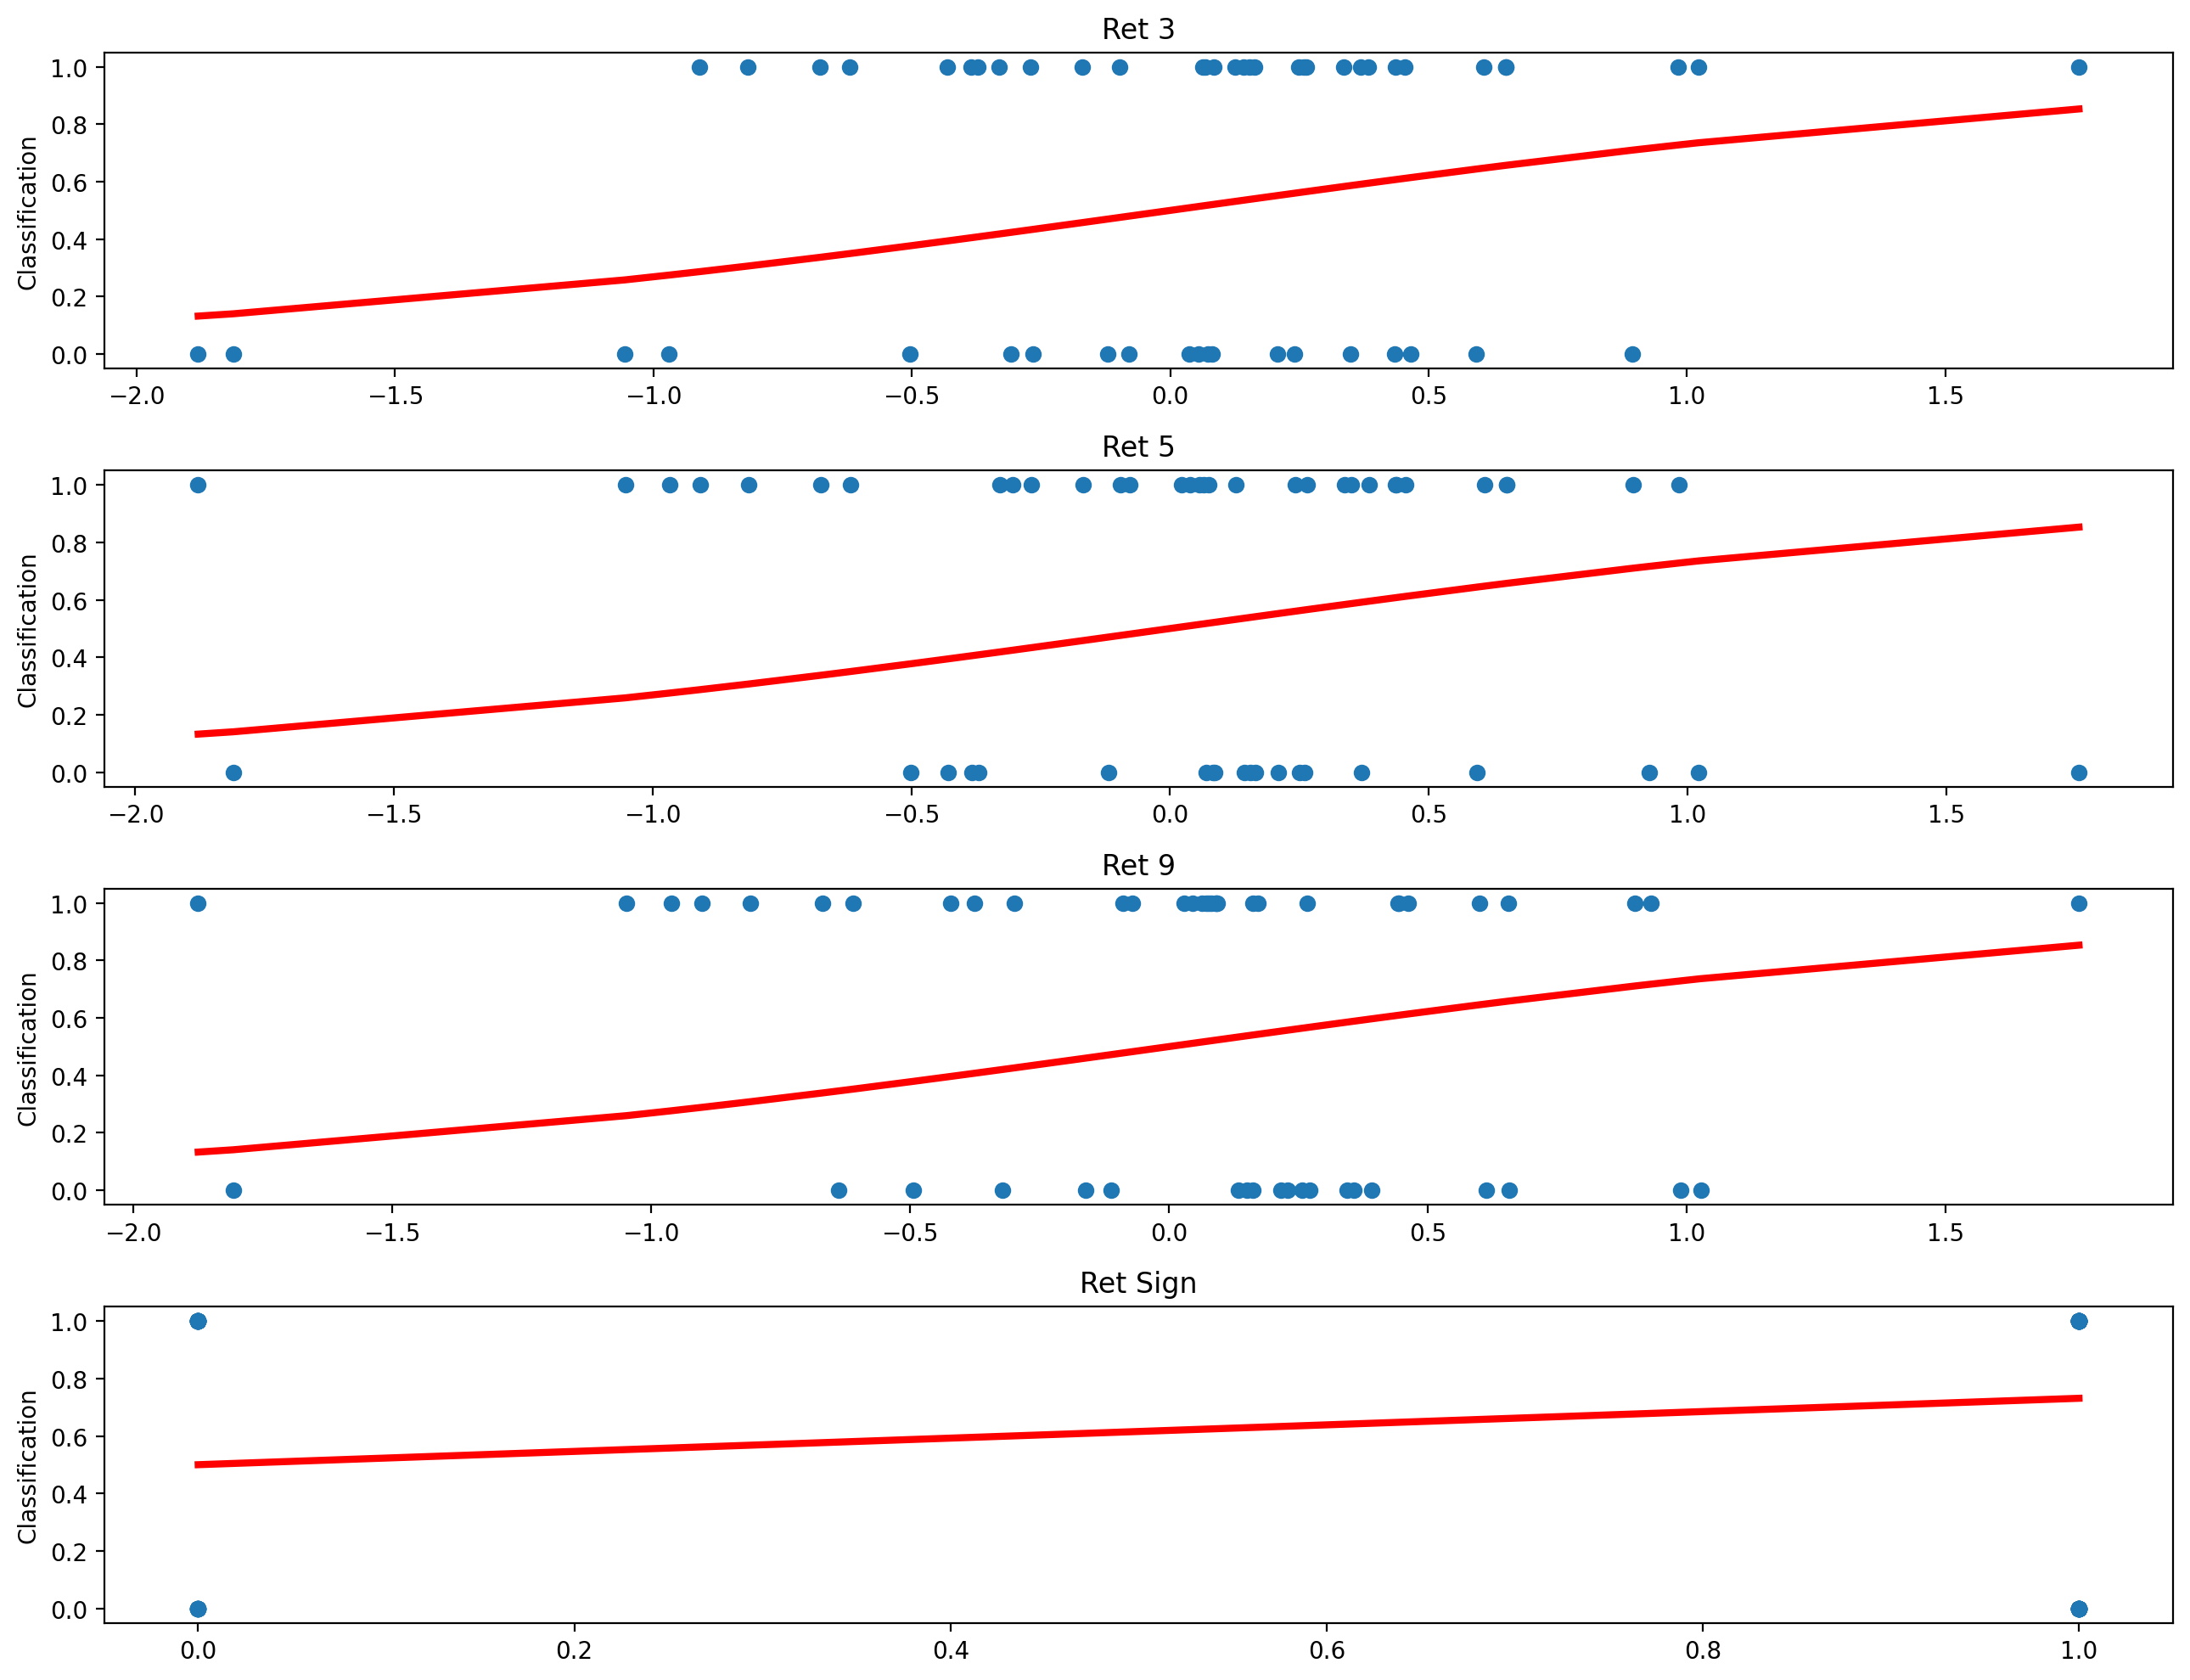

In [58]:
# Plotting of Logistic Sigmoid for the chosen 4 features

fig, axes=plt.subplots(4,1, figsize=(13, 10))
axes=axes.ravel()
chosen_features=[1,2,4,5]
titles=['Ret 3','Ret 5','Ret 9','Ret Sign']
for k in range(4):
    axes[k].scatter(X_test_scaled[:,int(chosen_features[k])], y_test)
    loss = expit(np.sort(X_test_scaled[:,int(chosen_features[k])]))
    axes[k].plot(np.sort(X_test_scaled[:,int(chosen_features[k])]), loss, color="red", linewidth=3)
    axes[k].set_title(titles[k])
    axes[k].set_ylabel('Classification')
fig.tight_layout()
plt.show()

# Part 4: evaluation of best model and prediction
We will now construct a new dataset with only the selected features and produce the evaluation of the model. Then we will evaluate its performance using the test set.

In [59]:
selected_columns = Features[['Ret 3','Ret 5','Ret 9','Ret sign']]
Best_feats=pd.DataFrame(selected_columns,index=df.index)
Best_feats.dropna(inplace=True)
Best_feats.head()

,Ret 3,Ret 5,Ret 9,Ret sign
Date,,,,
2020-10-22,-0.014418,0.061028,-0.005000,1.0
2020-10-23,-0.031348,-0.020182,-0.006030,-1.0
2020-10-26,-0.007551,-0.014418,-0.042467,1.0
2020-10-27,0.052174,-0.031348,-0.013728,1.0
2020-10-28,-0.019628,-0.007551,0.061028,-1.0


In [60]:
# Split dataset into training and validation

Xbest_train, Xbest_test, ybest_train, ybest_test = train_test_split(Best_feats, y, test_size=0.2, random_state=0, shuffle=False)

In [61]:
# Define a new ColumnTranformer to scale different columns in the approriate way

normalisable=[0,1]
minmaxable=[2,3]
column_transf_best=ColumnTransformer([
    ('normaliser', PowerTransformer(method='yeo-johnson'),normalisable),
      ('MinMax ',MinMaxScaler(),minmaxable)])

In [62]:
# Define and fit Ridge Logistic regression for best features

pipeRidge_best = Pipeline([("column_transformer",column_transf_best),
                      ("classifier", LogisticRegression(penalty='l2',solver='lbfgs',max_iter=200,C=0.402,random_state=None))]) 
pipeRidge_best.fit(Xbest_train, ybest_train)

Pipeline(steps=[('column_transformer',
                 ColumnTransformer(transformers=[('normaliser',
                                                  PowerTransformer(), [0, 1]),
                                                 ('MinMax ', MinMaxScaler(),
                                                  [2, 3])])),
                ('classifier', LogisticRegression(C=0.402, max_iter=200))])

In [63]:
# Perform Gridsearch and fit
param_grid = {'classifier__C': np.arange(0.002,15,0.05)}

grid_search_best = GridSearchCV(pipeRidge_best, param_grid, scoring='roc_auc', n_jobs=-1, cv=None, verbose=1)
grid_search_best.fit(Xbest_train, ybest_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits


GridSearchCV(estimator=Pipeline(steps=[('column_transformer',
                                        ColumnTransformer(transformers=[('normaliser',
                                                                         PowerTransformer(),
                                                                         [0,
                                                                          1]),
                                                                        ('MinMax ',
                                                                         MinMaxScaler(),
                                                                         [2,
                                                                          3])])),
                                       ('classifier',
                                        LogisticRegression(C=0.402,
                                                           max_iter=200))]),
             n_jobs=-1,
             param_grid={'classifier__C': array([2.0000e-03, 5.2000e-02, 1.0200e-01, 1.5200e-01, 2.0200e-01,
       2.5200e-01, 3.0200e-01, 3....
       1.3502e+01, 1.3552e+01, 1.3602e+01, 1.3652e+01, 1.3702e+01,
       1.3752e+01, 1.3802e+01, 1.3852e+01, 1.3902e+01, 1.3952e+01,
       1.4002e+01, 1.4052e+01, 1.4102e+01, 1.4152e+01, 1.4202e+01,
       1.4252e+01, 1.4302e+01, 1.4352e+01, 1.4402e+01, 1.4452e+01,
       1.4502e+01, 1.4552e+01, 1.4602e+01, 1.4652e+01, 1.4702e+01,
       1.4752e+01, 1.4802e+01, 1.4852e+01, 1.4902e+01, 1.4952e+01])},
             scoring='roc_auc', verbose=1)

In [64]:
# Best Params
grid_search_best.best_params_

{'classifier__C': 6.102}

We can see that there is some overfitting as the train accuracy is greater than the test accuracy

In [65]:
# Predicting the test dataset
y_pred = pipeRidge_best.predict(Xbest_test)
acc_train = accuracy_score(ybest_train, pipeRidge_best.predict(Xbest_train))
acc_test = accuracy_score(ybest_test, y_pred)
print(f'Train Accuracy: {acc_train:0.4}, Test Accuracy: {acc_test:0.4}')

Train Accuracy: 0.5686, Test Accuracy: 0.3846


In [66]:
# Confusion Matrix for binary classification
tn, fp, fn, tp = confusion_matrix(ybest_test, y_pred).ravel()
print(tn, fp, fn, tp)

6 14 18 14


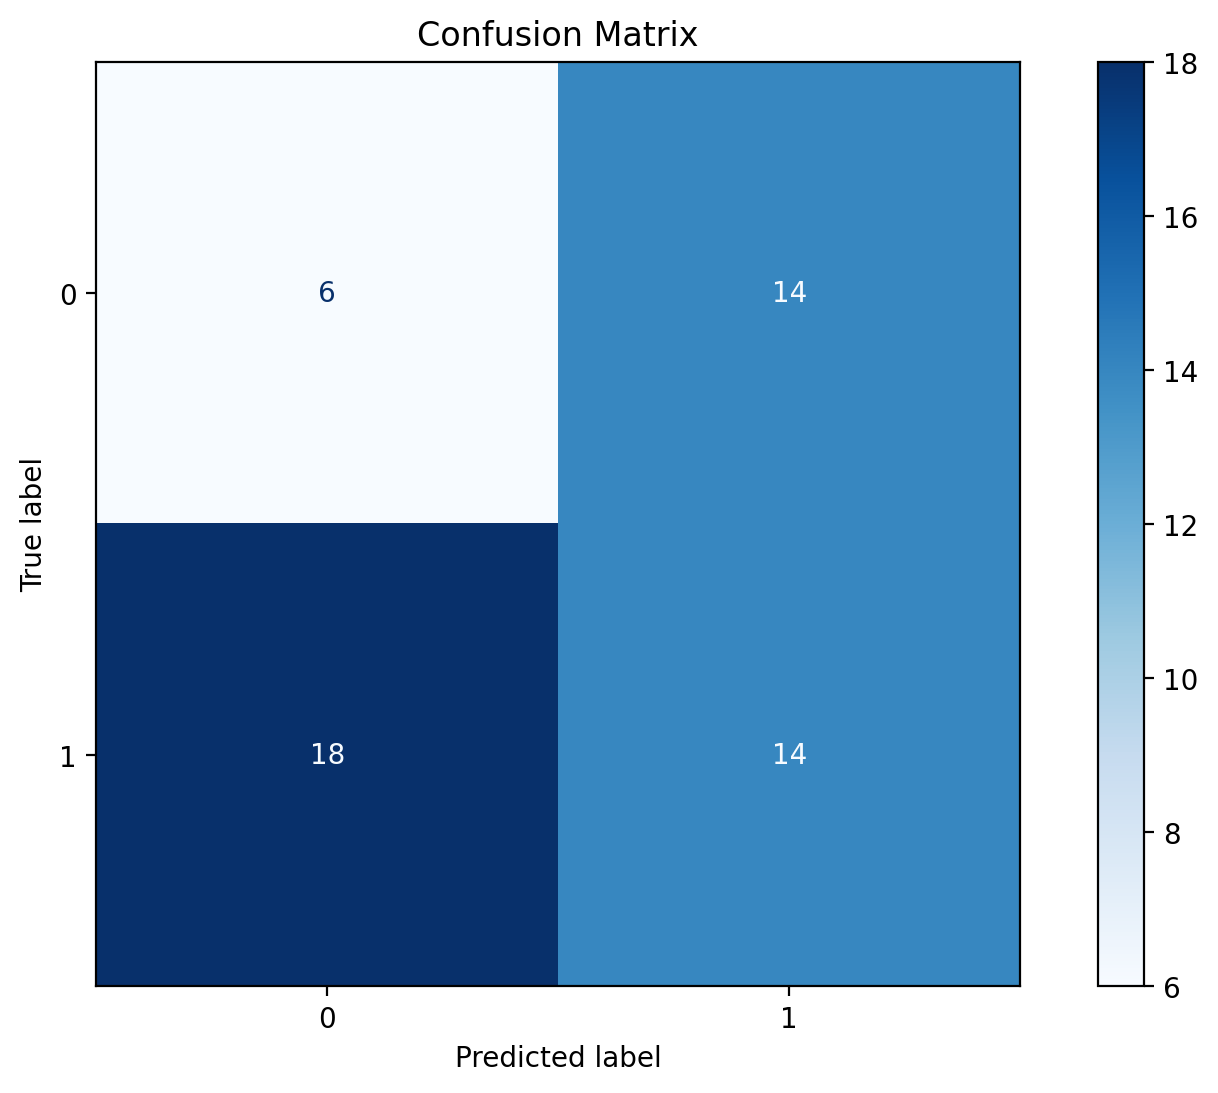

In [69]:
# Plot confusion matrix
ConfusionMatrixDisplay.from_estimator(
    pipeRidge_best,
    Xbest_test,
    ybest_test,
    display_labels=pipeRidge_best.classes_,  # Adjust this if you need specific class labels
    cmap='Blues',
    values_format='.4g'
)

plt.title('Confusion Matrix')
plt.grid(False)
plt.show()

### Area under the ROC curve

In [70]:
# Predict Probabilities
probs = pipeRidge_best.predict_proba(Xbest_test)
preds1 = probs[:, 0]
preds2 = probs[:, 1]

fpr1, tpr1, threshold1 = roc_curve(ybest_test, preds1, pos_label=0)
roc_auc1 = auc(fpr1, tpr1)

fpr2, tpr2, threshold2 = roc_curve(ybest_test, preds2, pos_label=1)
roc_auc2 = auc(fpr2, tpr2)

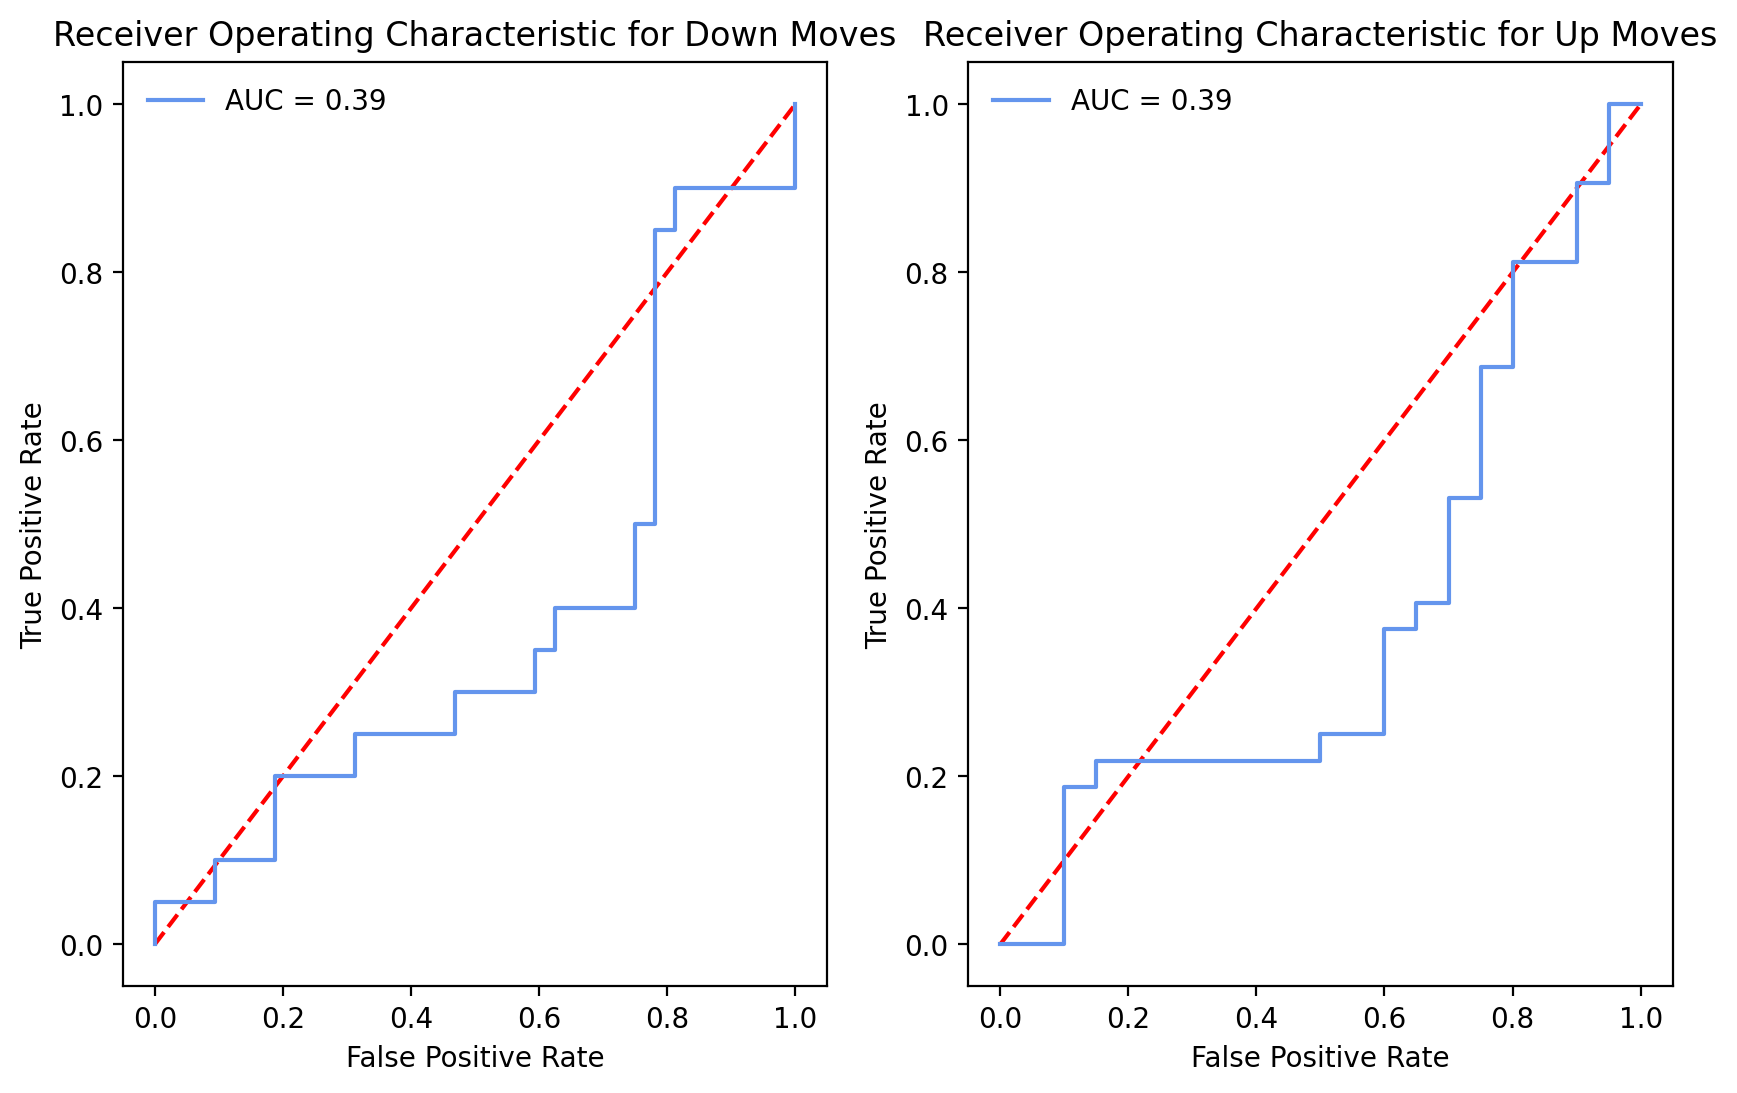

In [71]:
fig, ax = plt.subplots(nrows=1, ncols=2)

ax[0].plot([0, 1], [0, 1], 'r--')
ax[0].plot(fpr1, tpr1, 'cornflowerblue', label=f'AUC = {roc_auc1:0.2}')
ax[0].set_title("Receiver Operating Characteristic for Down Moves")
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')

ax[1].plot([0, 1], [0, 1], 'r--')
ax[1].plot(fpr2, tpr2, 'cornflowerblue', label=f'AUC = {roc_auc2:0.2}')
ax[1].set_title("Receiver Operating Characteristic for Up Moves")
ax[1].set_xlabel('False Positive Rate')
ax[1].set_ylabel('True Positive Rate')

# Define legend
ax[0].legend(), ax[1].legend();

### Classification report

In [72]:
# Classification Report
print(classification_report(ybest_test, y_pred))

              precision    recall  f1-score   support

           0       0.25      0.30      0.27        20
           1       0.50      0.44      0.47        32

    accuracy                           0.38        52
   macro avg       0.38      0.37      0.37        52
weighted avg       0.40      0.38      0.39        52



# Part 5: Probability prediction
We call predict_proba() to predict probabilities of up and down moves, then we analysie them through scatter plots

In [73]:
# Predicting the test dataset
y_probab = pipeRidge_best.predict_proba(Xbest_test)
y_pred= pipeRidge_best.predict(Xbest_test)

In [74]:
# Separates correclty and incorrectly predicted values for the scatter plot

# Initialising lists
trueups=[]
falseups=[]
truedown=[]
falsedown=[]


# The probabilities of true/false negative/positives are slotted in the correct list
for i in range(len(ybest_test)):
    if y_pred[i]==ybest_test[i]:
        if ybest_test[i]==1:
            trueups.append(y_probab[i,1])
        else:
            truedown.append(y_probab[i,0])
    else:
        if ybest_test[i]==1:
            falseups.append(y_probab[i,1])
        else:
            falsedown.append(y_probab[i,0])

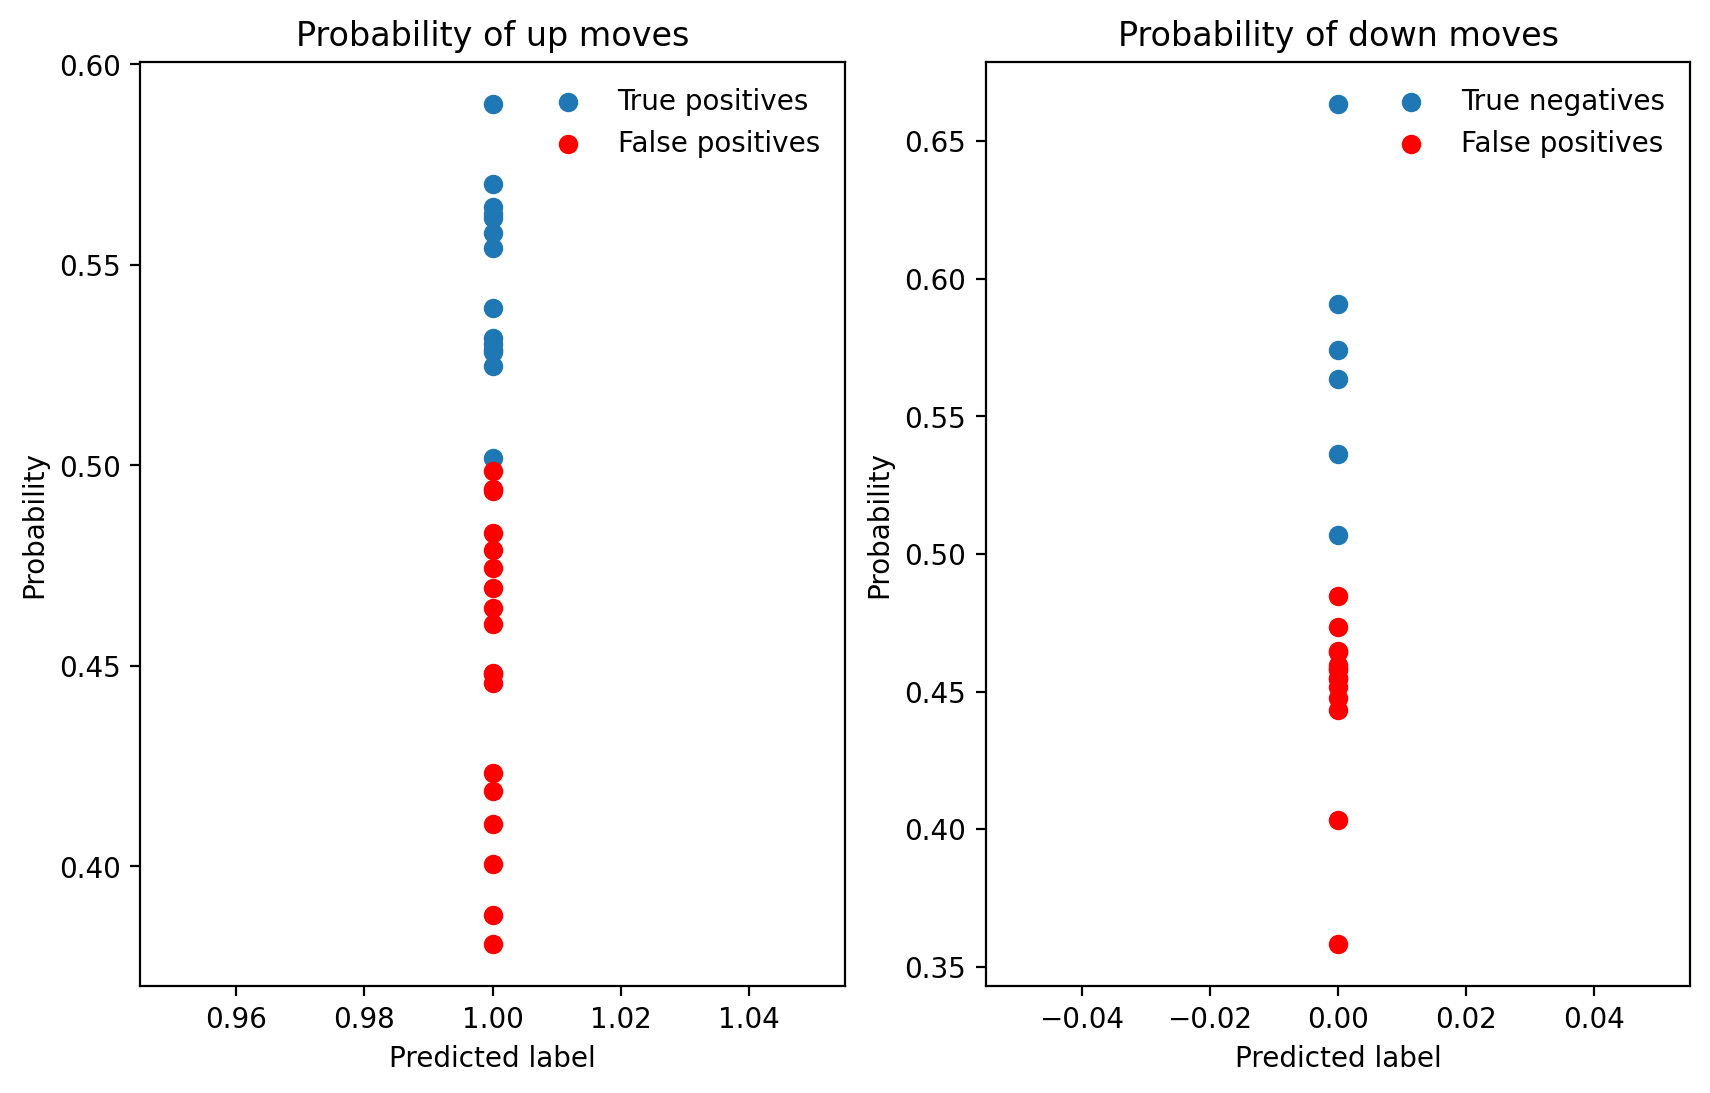

In [75]:
fig, (ax1,ax2)=plt.subplots(1,2)
ax1.scatter(np.ones(len(trueups)),trueups,label='True positives')
ax1.scatter(np.ones(len(falseups)),falseups,color='red',label='False positives')
ax2.scatter(np.zeros(len(truedown)),truedown,label='True negatives')
ax2.scatter(np.zeros(len(falsedown)),falsedown,color='red',label='False positives')
ax1.set_title('Probability of up moves')
ax2.set_title('Probability of down moves')
ax1.set_ylabel('Probability')
ax2.set_ylabel('Probability')
ax1.set_xlabel('Predicted label')
ax2.set_xlabel('Predicted label')
ax1.legend()
ax2.legend()